<a href="https://colab.research.google.com/github/Kennenzz/predict-employee-attrition/blob/main/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**XÂY DỰNG MÔ HÌNH DỰ ĐOÁN NGUY CƠ NGHỈ VIỆC CỦA NHÂN VIÊN**
---

**#Import các thư viện sẽ sử dụng trong đồ án bao gồm:**
*   **Pandas**
*   **Numpy**
*   **Matplotlib**
*   **Seaborn**
*   **Matplotlib**
*   **Imblearn**
*   **Sklearn**
*   **LightGBM**
*   **XGBoost**
*   **Pytorch Tabnet**

In [1]:
import pandas as pd
import joblib
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from pytorch_tabnet.tab_model import TabNetClassifier
import lightgbm as lgb
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

---
**Đọc file dataset**

In [2]:
try:
    df = pd.read_csv("Dataset.csv")
    display(df.head())
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file dataset trong dữ liệu folder")
except Exception as e:
    print(f"Có lỗi xảy ra: {e}")

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


---
**Mô tả tổng quan về dataset**

In [3]:
display(df.info())
display(df.describe())
display(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

None

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


(1470, 35)

**Tổng quan: Dataset thông tin của nhân viên gồm có 1470 mẫu và 35 cột (thuộc tinh)**


---
# Phân loại các biến trong dataset

In [4]:
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include='object').columns

print("Biến số:")
display(numerical_cols)

print("\nBiến phân loại:")
display(categorical_cols)

Biến số:


Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')


Biến phân loại:


Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

---
**Tiền xử lý dữ liệu**

In [5]:
# Xử lý chuẩn hóa dữ liệu
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Chuyển đổi sang kiểu số, lỗi sẽ thành NaN
    if df[col].isnull().any():
        print(f"Cảnh báo: Cột '{col}' có giá trị không thể chuyển đổi sang số.")
    print(f"Cột '{col}' đã được chuyển đổi sang kiểu số.")


for col in categorical_cols:
    unique_values = df[col].unique()
    print(f"Giá trị duy nhất trong cột '{col}': {unique_values}")
    df[col] = df[col].str.strip().str.lower()   # Loại bỏ khoảng trắng và chuyển về chữ thường  
    unique_values_after = df[col].unique()
    print(f"Giá trị duy nhất trong cột '{col}' sau khi xử lý: {unique_values_after}")

Cột 'Age' đã được chuyển đổi sang kiểu số.
Cột 'DailyRate' đã được chuyển đổi sang kiểu số.
Cột 'DistanceFromHome' đã được chuyển đổi sang kiểu số.
Cột 'Education' đã được chuyển đổi sang kiểu số.
Cột 'EmployeeCount' đã được chuyển đổi sang kiểu số.
Cột 'EmployeeNumber' đã được chuyển đổi sang kiểu số.
Cột 'EnvironmentSatisfaction' đã được chuyển đổi sang kiểu số.
Cột 'HourlyRate' đã được chuyển đổi sang kiểu số.
Cột 'JobInvolvement' đã được chuyển đổi sang kiểu số.
Cột 'JobLevel' đã được chuyển đổi sang kiểu số.
Cột 'JobSatisfaction' đã được chuyển đổi sang kiểu số.
Cột 'MonthlyIncome' đã được chuyển đổi sang kiểu số.
Cột 'MonthlyRate' đã được chuyển đổi sang kiểu số.
Cột 'NumCompaniesWorked' đã được chuyển đổi sang kiểu số.
Cột 'PercentSalaryHike' đã được chuyển đổi sang kiểu số.
Cột 'PerformanceRating' đã được chuyển đổi sang kiểu số.
Cột 'RelationshipSatisfaction' đã được chuyển đổi sang kiểu số.
Cột 'StandardHours' đã được chuyển đổi sang kiểu số.
Cột 'StockOptionLevel' đã được ch

Xử lý dữ liệu thiếu

In [6]:
df.isnull().sum()


Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

*Không có dữ liệu thiếu trong dataset*

*Xử lý dữ liệu dư thừa, dữ liệu gây nhiễu (không liên quan)*

In [7]:
df.drop(columns=['Over18', 'EmployeeNumber', 'EmployeeCount','StandardHours'], axis =1, inplace= True)
# Cập nhật lại danh sách biến phân loại sau khi loại bỏ cột
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include='object').columns

Qua quan sát dữ liệu thì có thể thấy các cột dữ liệu không cần thiết như sau:
*   **Over18** tất cả nhân viên đều đã trên 18 tuổi
*   **EmployeeCount** luôn có giá trị là 1
*   **EmployeeNumber** luôn có giá trị khác nhau như việc nhân viên có mã nhân viên
*   **StandardHours** luôn có giá trị là 80

In [8]:
display(df.info())
display(df.describe())
display(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

None

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,...,3.153741,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,...,0.360824,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,...,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,...,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,...,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,...,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,...,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


(1470, 31)

**Kiểu tra xem có dữ liệu trùng lặp hay không**

In [9]:

duplicate_rows = df[df.duplicated()]
print(f"Số hàng trùng lặp: {duplicate_rows.shape[0]}")
print("Các hàng trùng lặp:")
display(duplicate_rows)


Số hàng trùng lặp: 0
Các hàng trùng lặp:


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager


**Xử lý mã hóa biến phân loại**

In [10]:
print("Các biến phân loại sau khi loại bỏ cột không cần thiết:")
display(categorical_cols)


Các biến phân loại sau khi loại bỏ cột không cần thiết:


Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'OverTime'],
      dtype='object')

*Mã hóa biến mục tiêu "Attrition" thành 0/1 và xử lý mã hóa các biến phân loại*

In [11]:
label_encoder = LabelEncoder()
df['Attrition'] = label_encoder.fit_transform(df['Attrition'])

def mahoabienphanloai(encoder):
    for col in categorical_cols:
        if col not in ['Attrition','Over18']:  # Bỏ qua cột đã mã hóa hoặc không cần mã hóa
            df[col] = encoder.fit_transform(df[col])
mahoabienphanloai(label_encoder)

In [12]:
display(df.info())
# hiện 100 dòng đầu tiên
display(df.head(100))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       1470 non-null   int64
 1   Attrition                 1470 non-null   int64
 2   BusinessTravel            1470 non-null   int64
 3   DailyRate                 1470 non-null   int64
 4   Department                1470 non-null   int64
 5   DistanceFromHome          1470 non-null   int64
 6   Education                 1470 non-null   int64
 7   EducationField            1470 non-null   int64
 8   EnvironmentSatisfaction   1470 non-null   int64
 9   Gender                    1470 non-null   int64
 10  HourlyRate                1470 non-null   int64
 11  JobInvolvement            1470 non-null   int64
 12  JobLevel                  1470 non-null   int64
 13  JobRole                   1470 non-null   int64
 14  JobSatisfaction           1470 non-null 

None

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,2,1102,2,1,2,1,2,0,...,3,1,0,8,0,1,6,4,0,5
1,49,0,1,279,1,8,1,1,3,1,...,4,4,1,10,3,3,10,7,1,7
2,37,1,2,1373,1,2,2,4,4,1,...,3,2,0,7,3,3,0,0,0,0
3,33,0,1,1392,1,3,4,1,4,0,...,3,3,0,8,3,3,8,7,3,0
4,27,0,2,591,1,2,1,3,1,1,...,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,54,0,2,1217,1,2,4,5,1,0,...,3,1,1,16,5,1,4,3,0,3
96,24,0,2,1353,2,3,2,4,1,0,...,4,1,1,4,2,2,3,2,0,2
97,28,0,0,120,2,4,3,3,2,1,...,3,2,0,5,3,4,5,4,0,4
98,58,0,2,682,2,10,4,3,4,1,...,3,3,0,38,1,2,37,10,1,8


**Dùng IQR phát hiện các outliers và tạo ra bộ dữ liệu loại bỏ các outlier**

In [13]:
# Phát hiện ngoại lệ sử dụng IQR
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
print("IQR values:")
print(IQR)
outlier_condition = ((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR)))
outlier_indices = outlier_condition.any(axis=1)
print("Chỉ số của các hàng có ngoại lệ:")
print(outlier_indices[outlier_indices].index.tolist())
print(f"\nSố lượng ngoại lệ phát hiện: {outlier_indices.sum()}")
df_cleaned_outliers = df[~outlier_indices]
print(f"Số lượng mẫu ban đầu: {df.shape[0]}")
print(f"Số lượng mẫu sau khi loại bỏ ngoại lệ: {df_cleaned_outliers.shape[0]}")

IQR values:
Age                            13.00
DailyRate                     692.00
DistanceFromHome               12.00
Education                       2.00
EnvironmentSatisfaction         2.00
HourlyRate                     35.75
JobInvolvement                  1.00
JobLevel                        2.00
JobSatisfaction                 2.00
MonthlyIncome                5468.00
MonthlyRate                 12414.50
NumCompaniesWorked              3.00
PercentSalaryHike               6.00
PerformanceRating               0.00
RelationshipSatisfaction        2.00
StockOptionLevel                1.00
TotalWorkingYears               9.00
TrainingTimesLastYear           1.00
WorkLifeBalance                 1.00
YearsAtCompany                  6.00
YearsInCurrentRole              5.00
YearsSinceLastPromotion         3.00
YearsWithCurrManager            5.00
dtype: float64
Chỉ số của các hàng có ngoại lệ:
[0, 1, 4, 6, 7, 8, 10, 15, 16, 18, 20, 21, 23, 25, 26, 28, 29, 31, 32, 33, 38, 41, 43, 44

Do việc dùng IQR để loại bỏ các ngoại lệ trong dataset gây ra sự giảm sút lớn về mặt dữ liệu mẫu (loại bỏ đến 50% mẫu) nên sẽ dùng thêm phương pháp cắt tỉa winsorizing đặt các giá trị ngoại lai về 1 ngưỡng chứ không xóa bỏ hoàn toàn giá trị ngoại lai

In [14]:
# Dùng phương pháp winsorizing để xử lý ngoại lệ
from scipy.stats.mstats import winsorize
for col in numerical_cols:
    df[col] = winsorize(df[col], limits=[0.05, 0.05])
    # Cắt tỉa 5% ở hai đầu
    # Giữ lại 90% dữ liệu ở giữa, thay thế 5% giá trị nhỏ nhất và lớn nhất bằng ngưỡng tương ứng
    print(f"Cột '{col}' đã được xử lý ngoại lệ bằng phương pháp winsorizing.")

Cột 'Age' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'DailyRate' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'DistanceFromHome' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'Education' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'EnvironmentSatisfaction' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'HourlyRate' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'JobInvolvement' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'JobLevel' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'JobSatisfaction' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'MonthlyIncome' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'MonthlyRate' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'NumCompaniesWorked' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'PercentSalaryHike' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'PerformanceRating' đã được xử lý ngoại lệ bằng ph

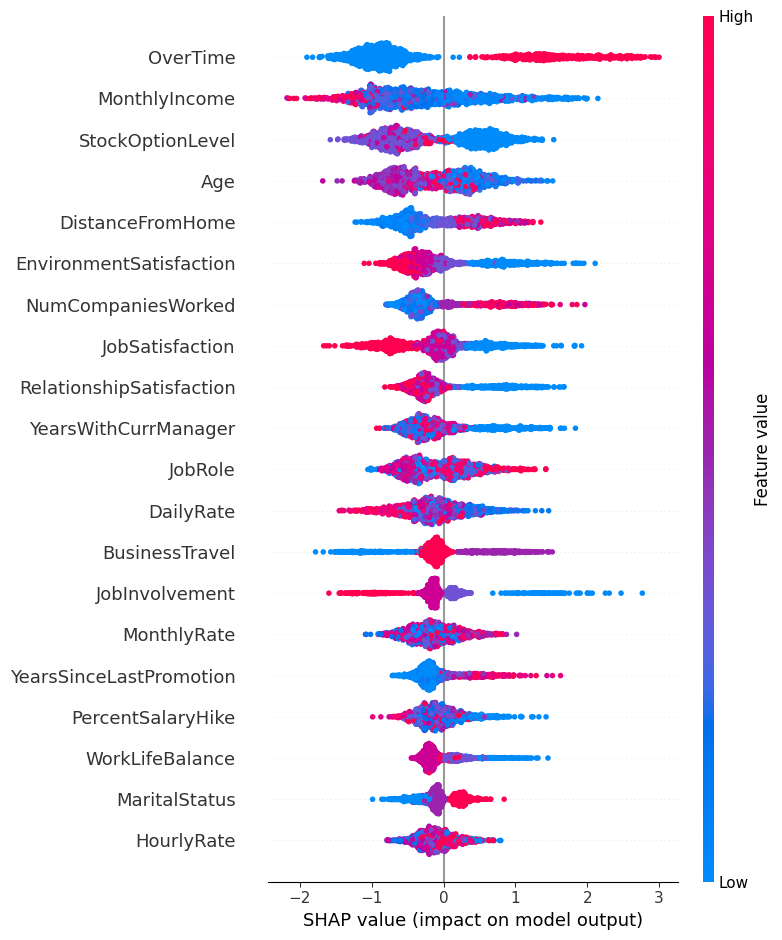

,Feature,Importance
18,OverTime,1.109685
15,MonthlyIncome,0.688121
22,StockOptionLevel,0.626588
0,Age,0.485489
4,DistanceFromHome,0.476011
7,EnvironmentSatisfaction,0.455625
17,NumCompaniesWorked,0.446869
13,JobSatisfaction,0.431542
21,RelationshipSatisfaction,0.378072
29,YearsWithCurrManager,0.372930


,OverTime,MonthlyIncome,StockOptionLevel,Age,DistanceFromHome,EnvironmentSatisfaction,NumCompaniesWorked,JobSatisfaction,RelationshipSatisfaction,YearsWithCurrManager,JobRole,DailyRate,Attrition
0,1,5993,0,41,1,2,8,4,1,5,7,1102,1
1,0,5130,1,49,8,3,1,2,4,7,6,279,0
2,1,2097,0,37,2,4,6,3,2,0,2,1373,1
3,1,2909,0,33,3,4,1,3,3,0,6,1392,0
4,0,3468,1,27,2,1,8,2,4,2,2,591,0


,OverTime,MonthlyIncome,StockOptionLevel,Age,DistanceFromHome,EnvironmentSatisfaction,NumCompaniesWorked,JobSatisfaction,RelationshipSatisfaction,YearsWithCurrManager,JobRole,DailyRate,Attrition
2,1,2090,0,37,2,4,6,3,2,0,2,1373,1
3,1,2909,0,33,3,4,1,3,3,0,6,1392,0
5,0,3068,0,32,2,4,0,4,3,6,2,1005,0
9,0,5237,2,36,27,3,6,3,2,7,0,1299,0
11,1,4193,0,29,15,4,0,3,4,8,2,153,0


In [15]:
# Phân tích và tìm ra các đặc trưng quan trọng trong bộ dữ liệu
X = df.drop('Attrition', axis=1)
y = df['Attrition']
shap_explainer = shap.TreeExplainer(XGBClassifier().fit(X, y))
shap_values = shap_explainer.shap_values(X)
shap.summary_plot(shap_values, X)
important_features = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': important_features})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
display(feature_importance)
# lưu lại 12 đặc trưng quan trọng nhất trong bộ dữ liệu khác
top_12_features = feature_importance['Feature'].head(12).tolist()
df_top_12 = df[top_12_features + ['Attrition']]
display(df_top_12.head())
df_top_12_cleaned_outliers = df_cleaned_outliers[top_12_features + ['Attrition']]
display(df_top_12_cleaned_outliers.head())


---
#**KHAI PHÁ DỮ LIỆU EDA**


*Tổng quan về tình hình nghỉ việc của nhân viên*

Số lượng nhân viên nghỉ việc và không nghỉ việc:


Attrition
0    1233
1     237
Name: count, dtype: int64

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8868\3138437406.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Attrition', palette='viridis')


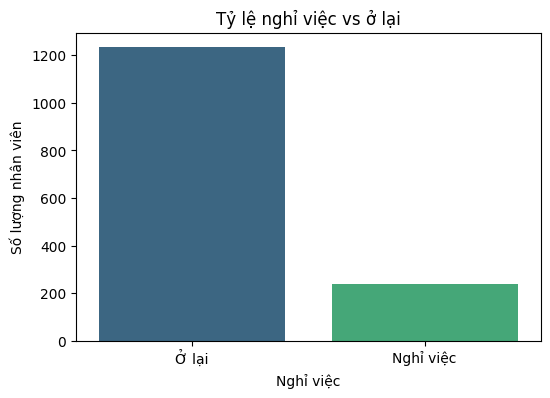


Phần trăm nhân viên nghỉ việc: 16.12%


In [16]:
# 1. Đếm số lượng nhân viên nghỉ việc và không nghỉ việc
attrition_counts = df['Attrition'].value_counts()
print("Số lượng nhân viên nghỉ việc và không nghỉ việc:")
display(attrition_counts)

# 2. Vẽ biểu đồ cột cho tỷ lệ nghỉ việc
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Attrition', palette='viridis')
plt.title('Tỷ lệ nghỉ việc vs ở lại')
plt.xticks([0, 1], ['Ở lại', 'Nghỉ việc'])
plt.xlabel('Nghỉ việc')
plt.ylabel('Số lượng nhân viên')
plt.show()

# 3. Hiển thị phần trăm nhân viên nghỉ việc
if 1 in attrition_counts.index:
	attrition_percentage = (attrition_counts[1] / len(df)) * 100
	print(f"\nPhần trăm nhân viên nghỉ việc: {attrition_percentage:.2f}%")
else:
	print("\nKhông tìm thấy giá trị '1' trong cột 'Attrition'. Kiểm tra lại dữ liệu mã hóa.")

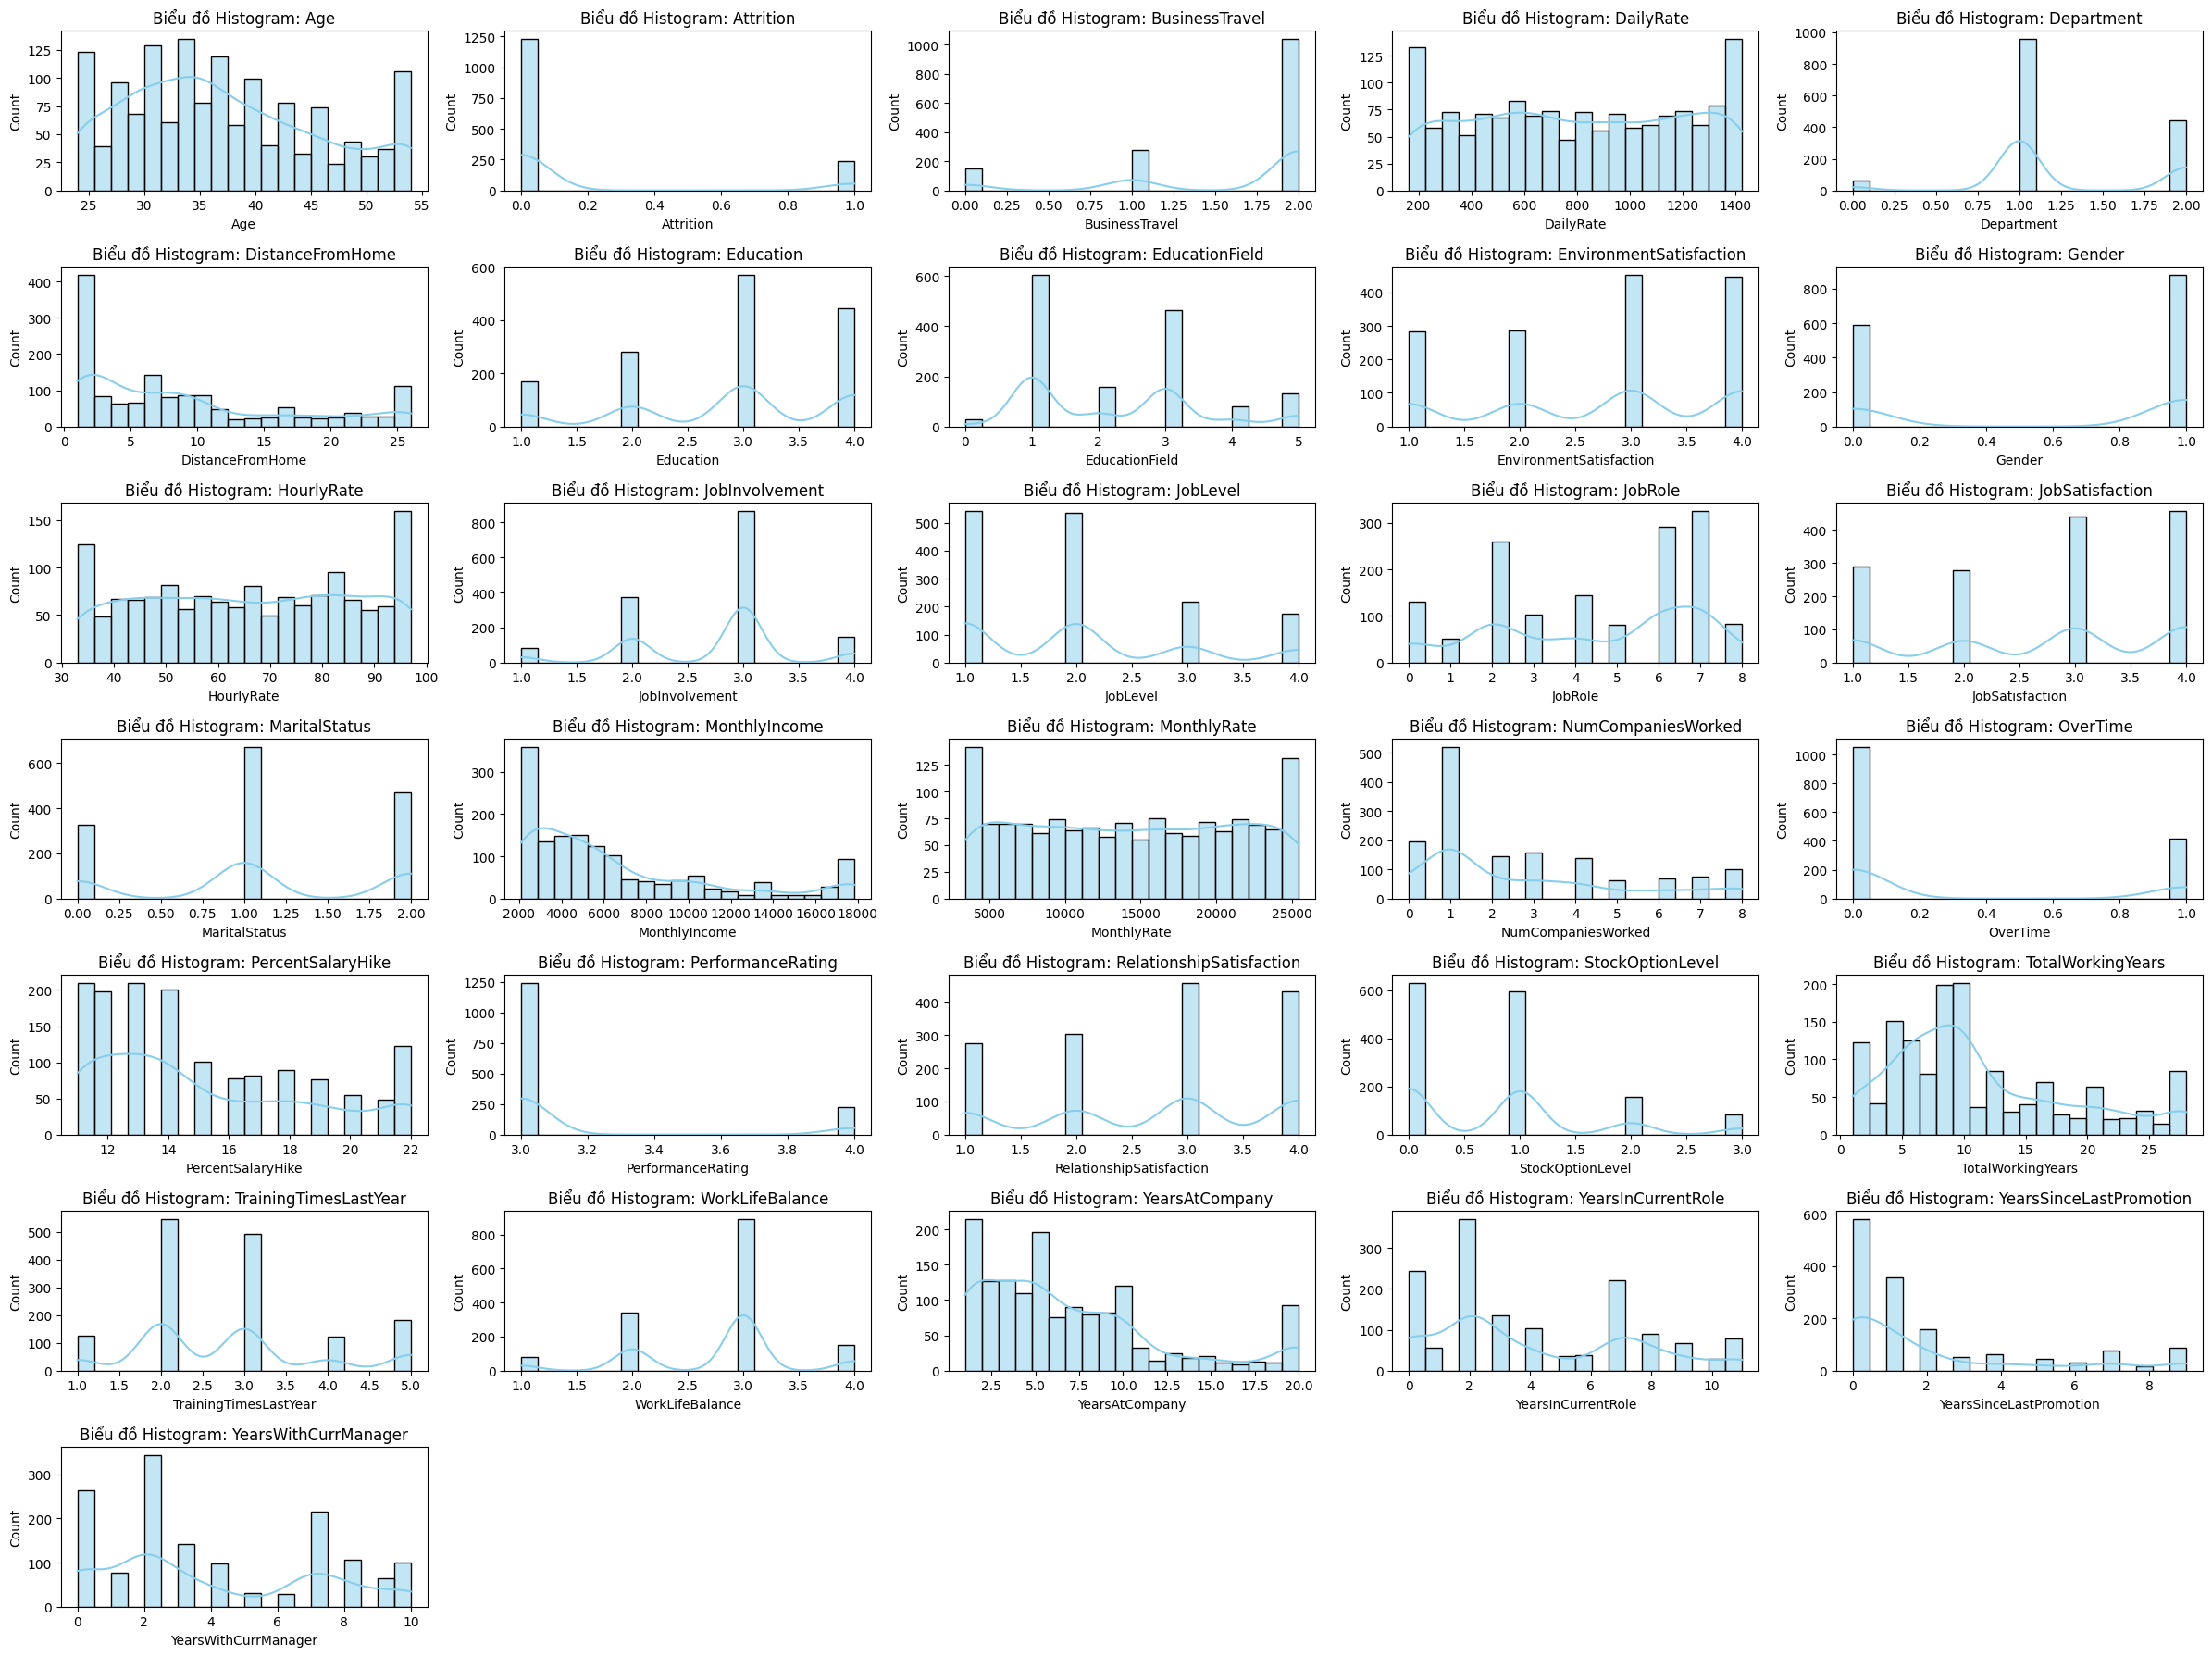

<Figure size 2400x1200 with 0 Axes>

In [17]:
# Lấy các biến số (loại trừ biến kiểu bool)
filtered_numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
# Tính số hàng và cột cho subplot
num_plots = len(filtered_numerical_cols)
cols = 5
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(24, 18))
for idx, col in enumerate(filtered_numerical_cols):
    plt.subplot(rows, cols, idx + 1)
    sns.histplot(df[col], bins=20, kde=True, color='skyblue')
    plt.title(f'Biểu đồ Histogram: {col}')
plt.tight_layout()
plt.show()

# Vẽ countplot cho các biến phân loại (chỉ vẽ cho các biến đã được mã hóa nhị phân)
plt.figure(figsize=(24, 12))
for i, col in enumerate(df.columns[df.dtypes == 'bool']):
    plt.subplot(4, 5, i + 1)
    sns.countplot(x=col, data=df, palette='viridis')
    plt.title(f'Biểu đồ Countplot: {col}')
plt.tight_layout()
plt.show()

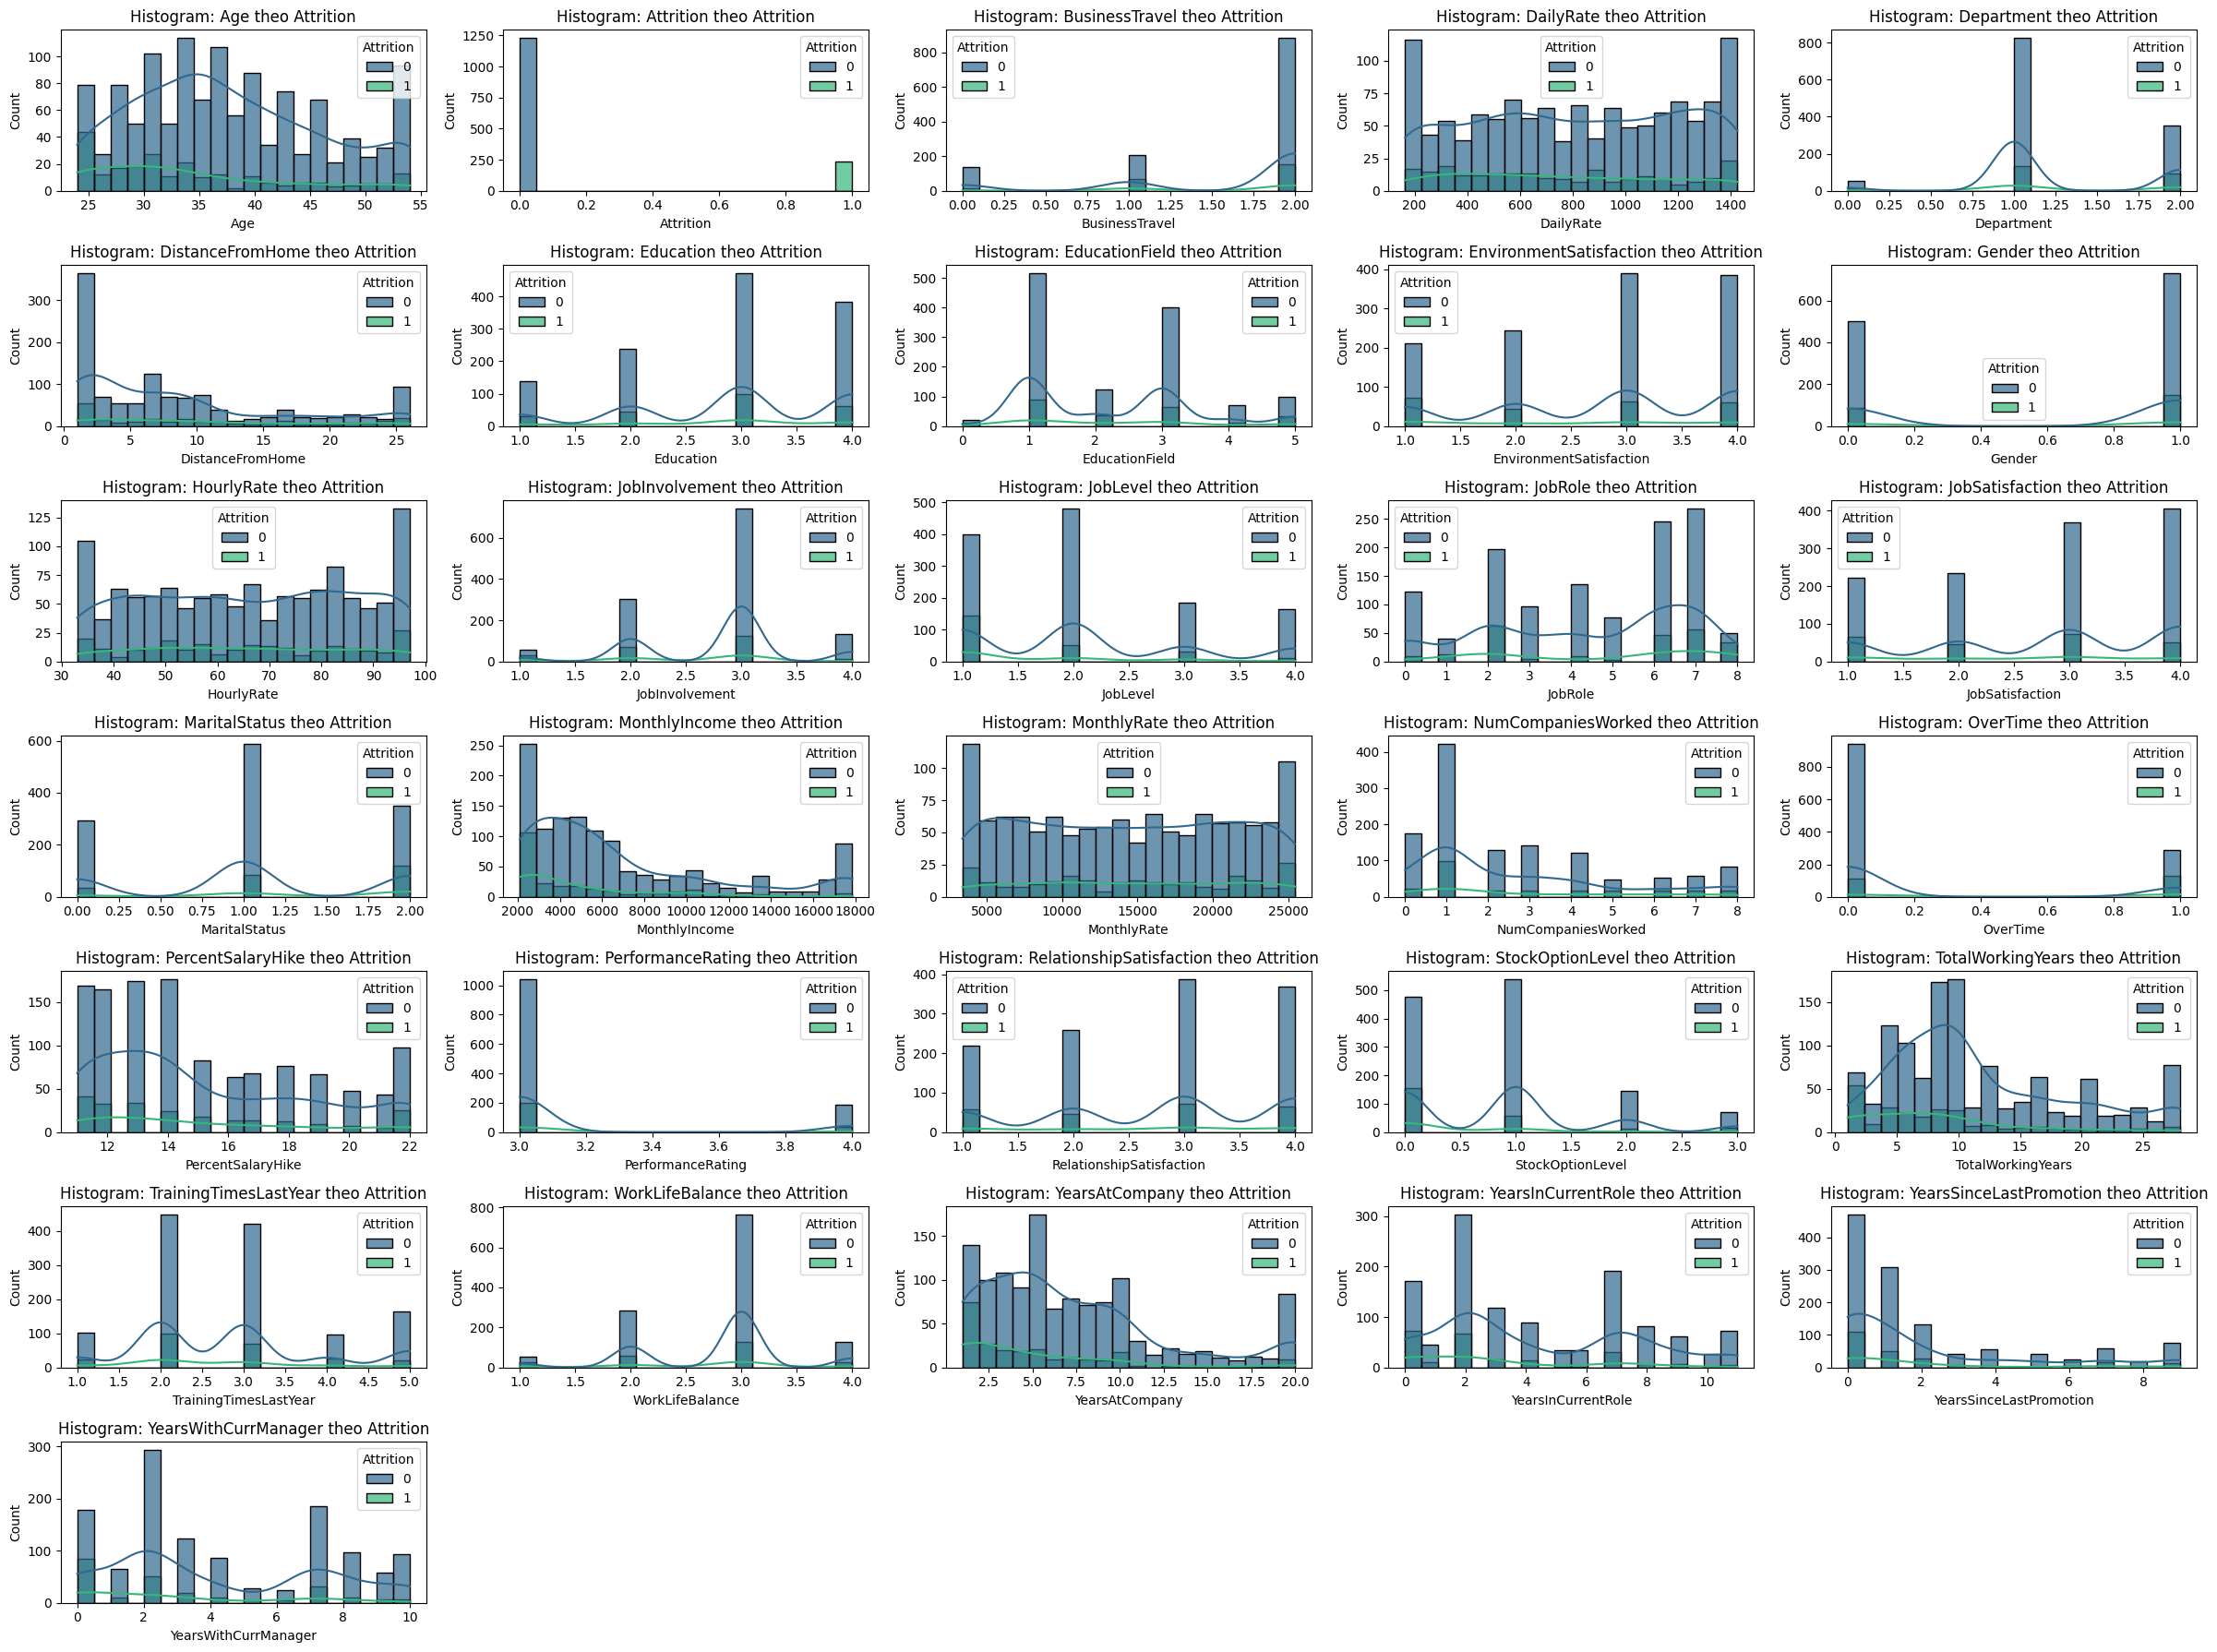

In [18]:
plt.figure(figsize=(24, 18))
for idx, col in enumerate(filtered_numerical_cols):
    plt.subplot(rows, cols, idx + 1)
    sns.histplot(data=df, x=col, hue='Attrition', bins=20, kde=True, palette='viridis', alpha=0.7)
    plt.title(f'Histogram: {col} theo Attrition')
plt.tight_layout()
plt.show()

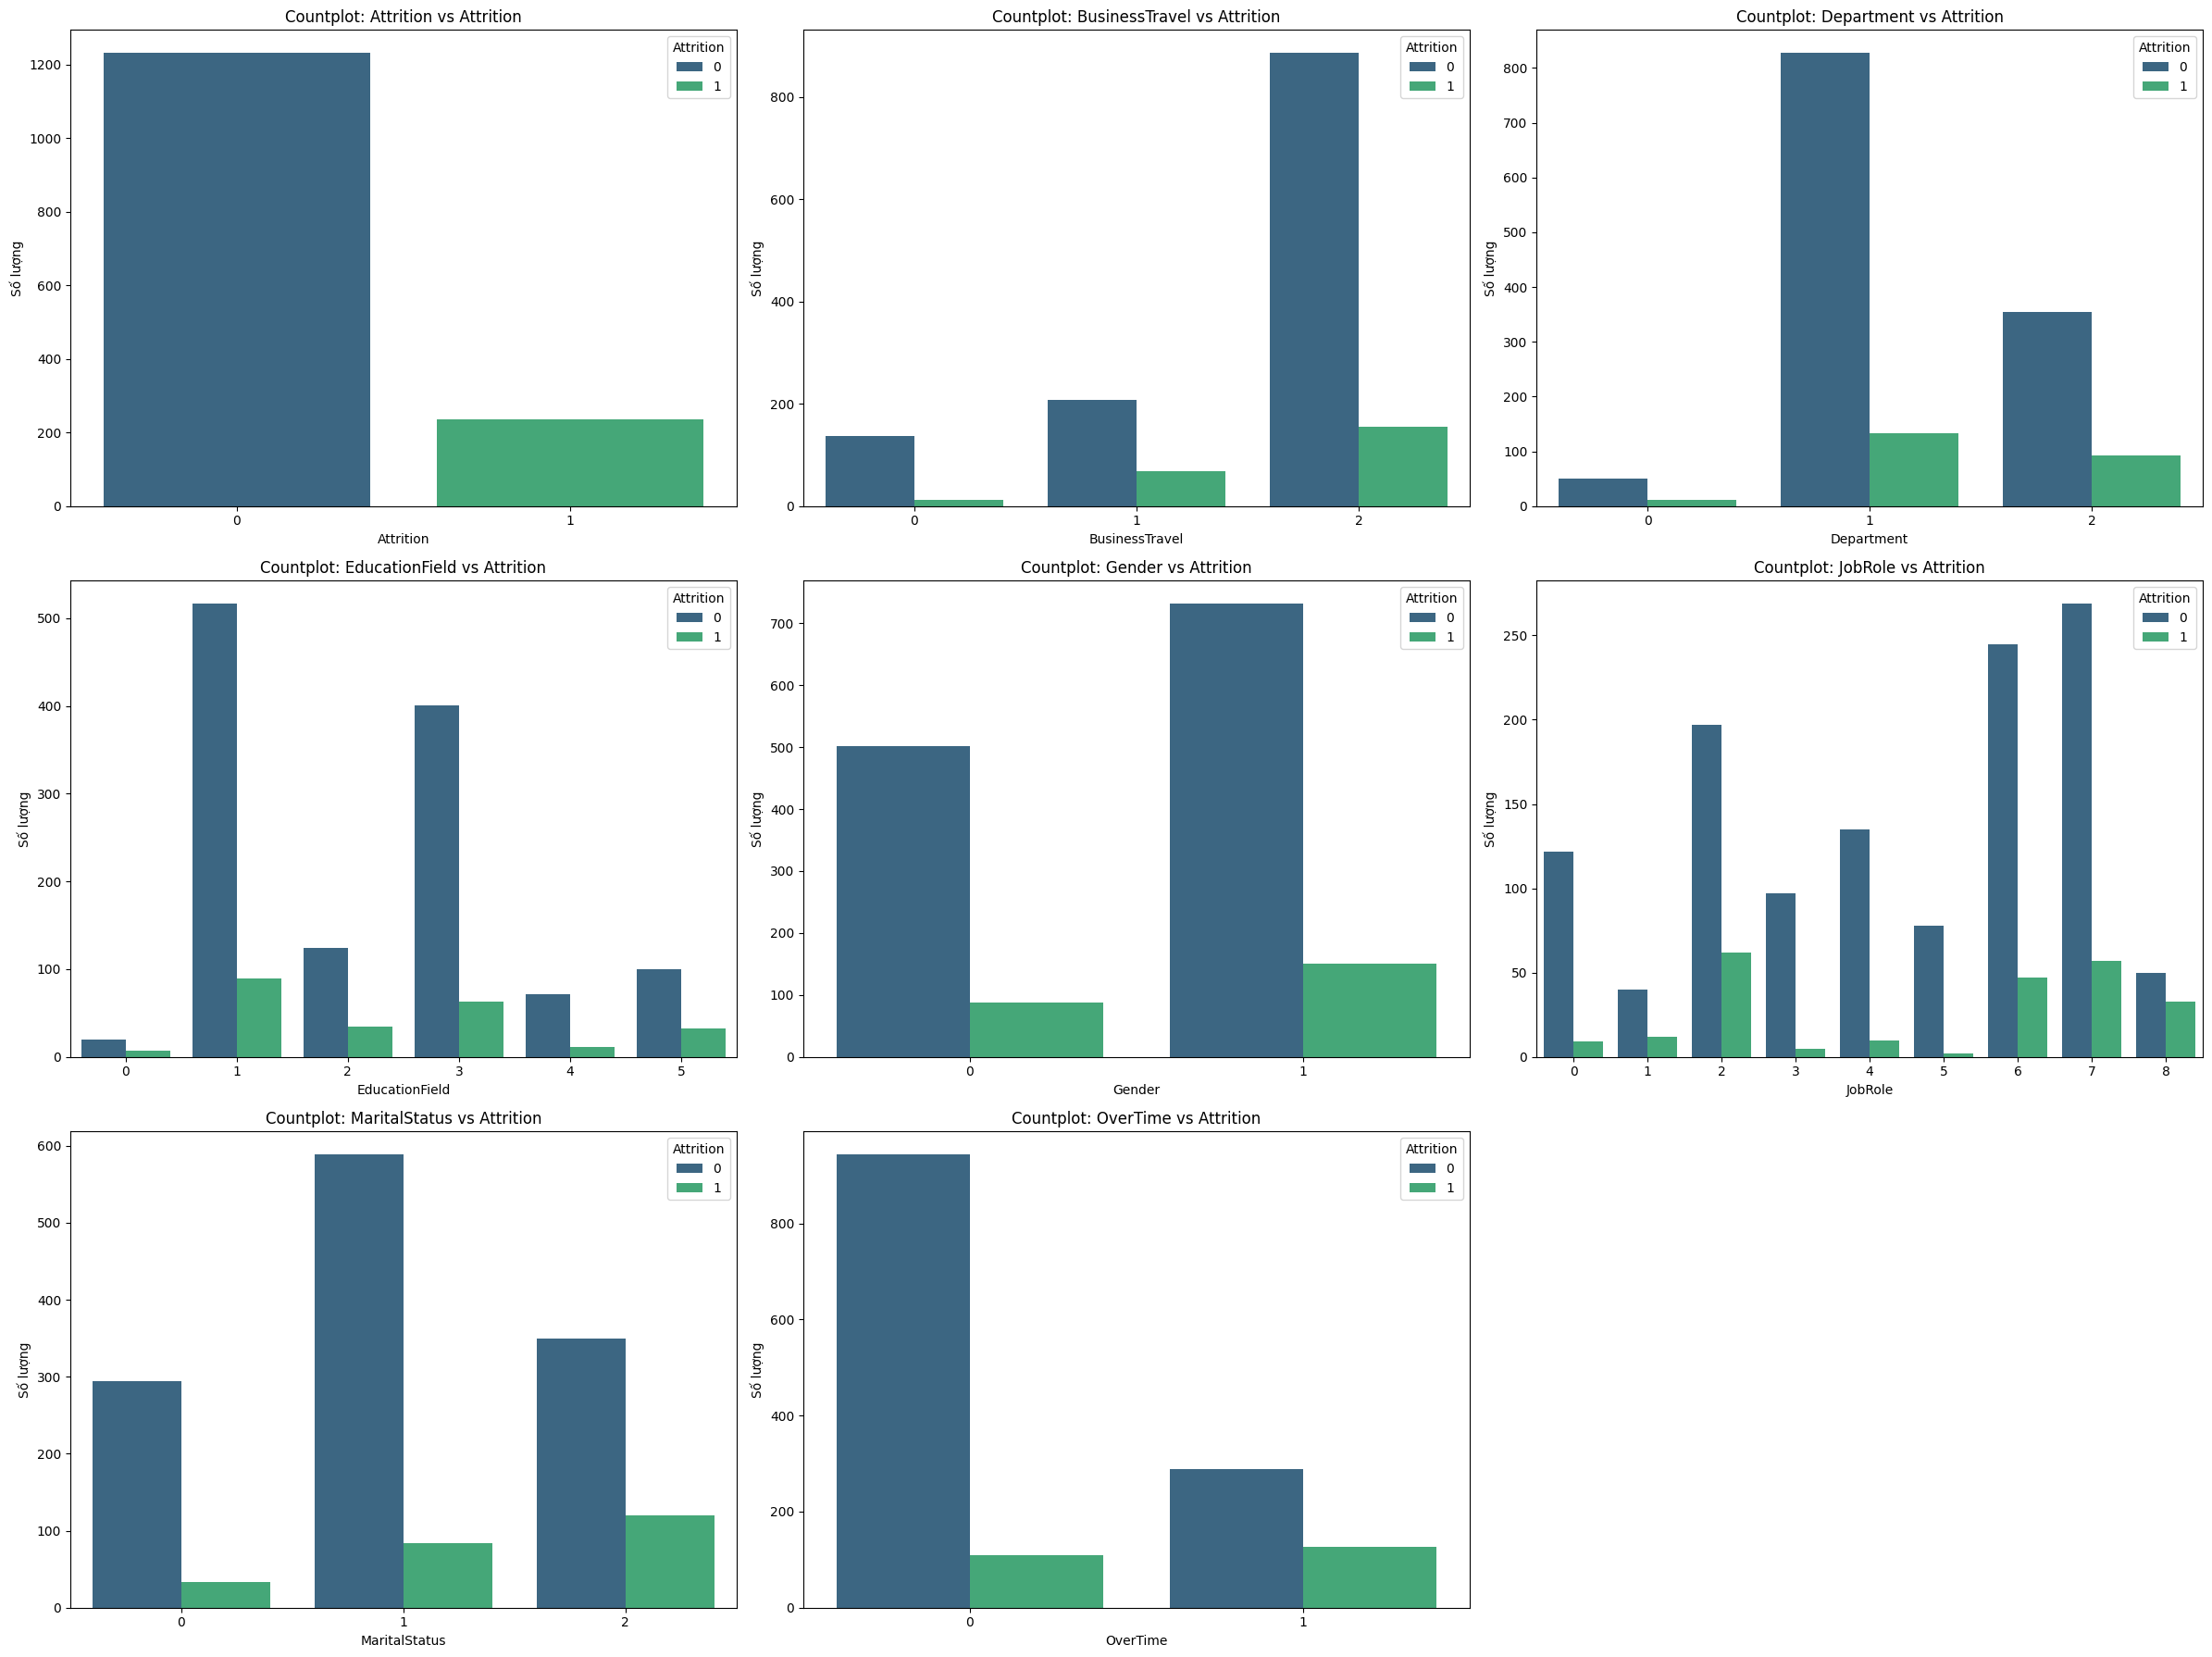

In [19]:
# Vẽ countplot giữa các biến phân loại và biến mục tiêu Attrition
plt.figure(figsize=(24, 18))
for idx, col in enumerate(categorical_cols):
    plt.subplot(3, 3, idx + 1)
    # Nếu cột đã được one-hot encoding, vẽ countplot cho từng biến mới liên quan
    related_cols = [c for c in df.columns if c.startswith(col + "_") or c == col]
    for rel_col in related_cols:
        sns.countplot(data=df, x=rel_col, hue='Attrition', palette='viridis')
        plt.title(f'Countplot: {rel_col} vs Attrition')
        plt.xlabel(rel_col)
        plt.ylabel('Số lượng')
    plt.title(f'Countplot: {col} vs Attrition')
    plt.xlabel(col)
    plt.ylabel('Số lượng')
plt.tight_layout()
plt.show()

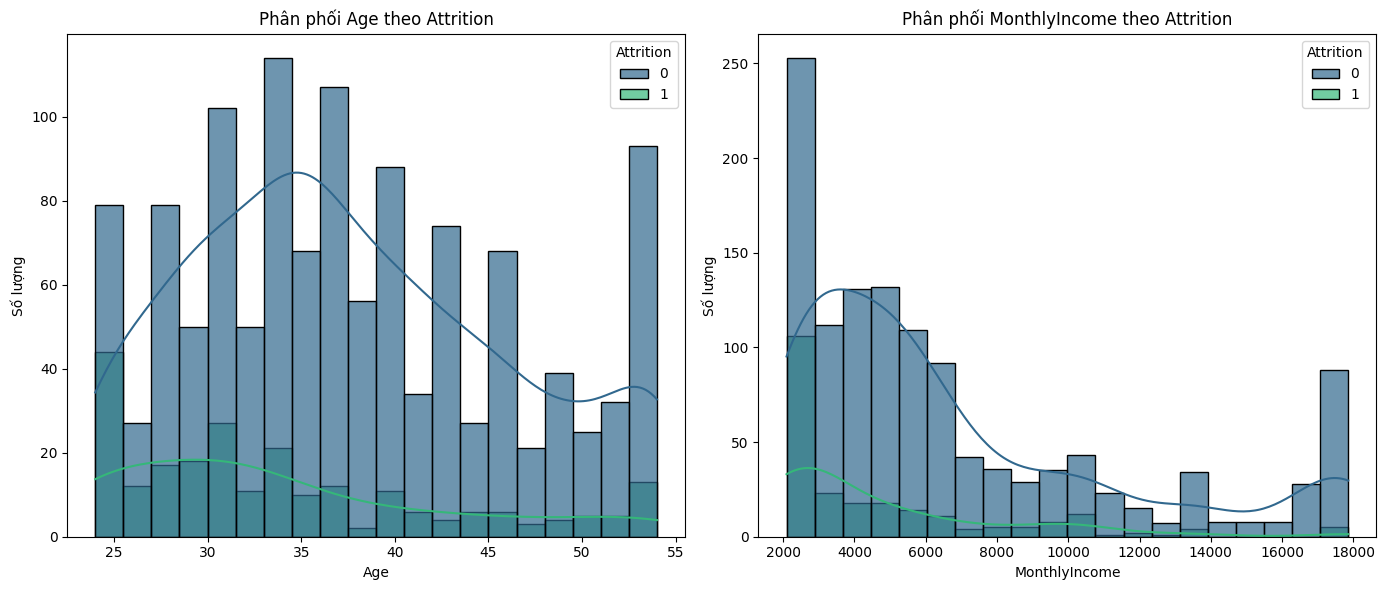

In [20]:
plt.figure(figsize=(14, 6))

# Histogram for Age
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Age', hue='Attrition', bins=20, kde=True, palette='viridis', alpha=0.7)
plt.title('Phân phối Age theo Attrition')
plt.xlabel('Age')
plt.ylabel('Số lượng')

# Histogram for MonthlyIncome
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='MonthlyIncome', hue='Attrition', bins=20, kde=True, palette='viridis', alpha=0.7)
plt.title('Phân phối MonthlyIncome theo Attrition')
plt.xlabel('MonthlyIncome')
plt.ylabel('Số lượng')

plt.tight_layout()
plt.show()

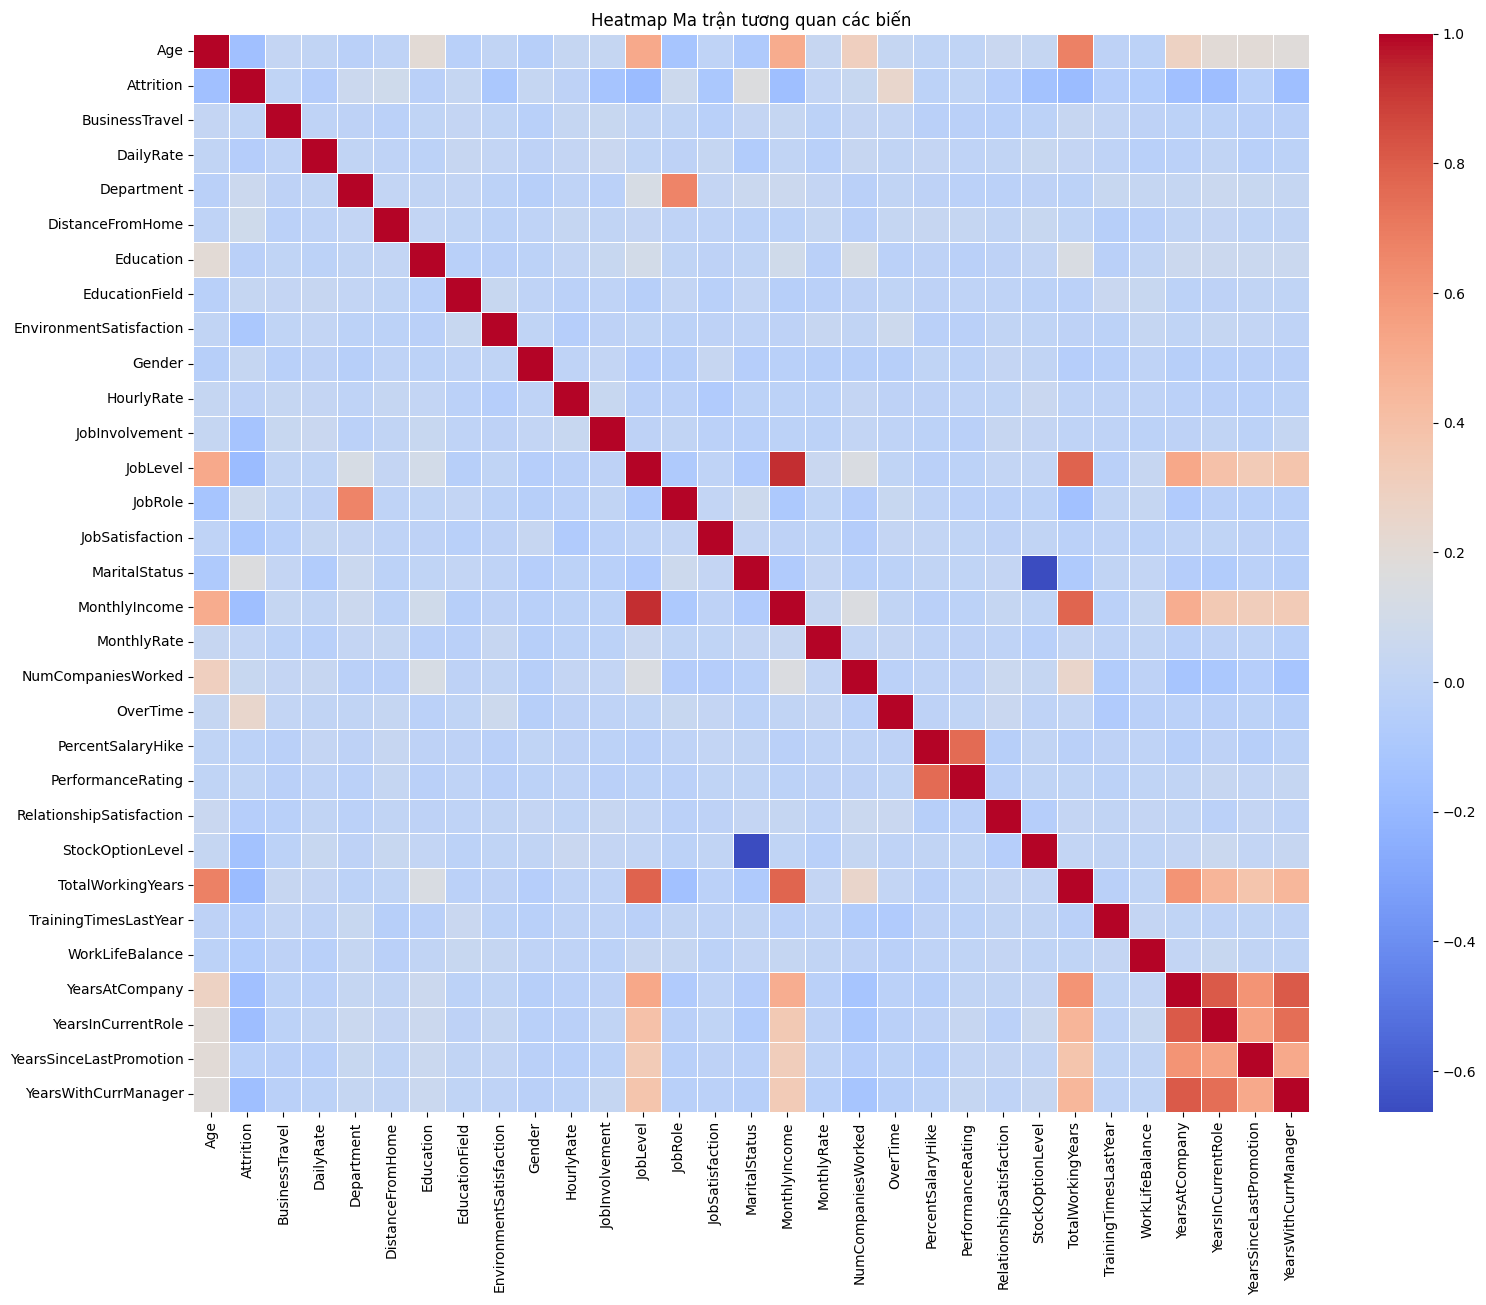

In [21]:
# Tính ma trận tương quan
corr_matrix = df.corr()

# Vẽ heatmap với seaborn
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap Ma trận tương quan các biến')
plt.show()

In [22]:

print("Phân phối của biến mục tiêu 'Attrition':")
print(df['Attrition'].value_counts(normalize=True))
print(df['Attrition'].value_counts())

Phân phối của biến mục tiêu 'Attrition':
Attrition
0    0.838776
1    0.161224
Name: proportion, dtype: float64
Attrition
0    1233
1     237
Name: count, dtype: int64


*Chia bộ dữ liệu ra làm 2 phần 70/30 để huấn luyện mô hình*

In [23]:
# chia bộ dữ liệu ra làm 2 phần 70/30 để huấn luyện mô hình
X = df.drop('Attrition', axis=1)
y = df['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Số lượng mẫu trong tập huấn luyện: {X_train.shape[0]}")
print(f"Số lượng mẫu trong tập kiểm tra: {X_test.shape[0]}")
print(f"Số lượng mẫu trong tập huấn luyện theo lớp:\n{y_train.value_counts()}")
print(f"Số lượng mẫu trong tập kiểm tra theo lớp:\n{y_test.value_counts()}")

# chia bộ dữ liệu đã loại bỏ outliers ra làm 2 phần 70/30
X_cleaned_outliers = df_cleaned_outliers.drop('Attrition', axis=1)
y_cleaned_outliers = df_cleaned_outliers['Attrition']
X_cleaned_outliers_train, X_cleaned_outliers_test, y_cleaned_outliers_train, y_cleaned_outliers_test = train_test_split(
	X_cleaned_outliers, y_cleaned_outliers, test_size=0.3, random_state=42, stratify=y_cleaned_outliers
)
print(f"Số lượng mẫu trong tập huấn luyện (sau khi resample và loại bỏ ngoại lệ): {X_cleaned_outliers_train.shape[0]}")
print(f"Số lượng mẫu trong tập kiểm tra (sau khi resample và loại bỏ ngoại lệ): {X_cleaned_outliers_test.shape[0]}")
print(f"Số lượng mẫu trong tập huấn luyện theo lớp (sau khi resample và loại bỏ ngoại lệ):\n{y_cleaned_outliers_train.value_counts()}")
print(f"Số lượng mẫu trong tập kiểm tra theo lớp (sau khi resample và loại bỏ ngoại lệ):\n{y_cleaned_outliers_test.value_counts()}")

# Chia bộ dữ liệu chỉ có 12 đặc trưng quan trọng nhất ra làm 2 phần 70/30
X_top_12 = df_top_12.drop('Attrition', axis=1)
y_top_12 = df_top_12['Attrition']
X_top_12_train, X_top_12_test, y_top_12_train, y_top_12_test = train_test_split(X_top_12, y_top_12, test_size=0.3, random_state=42, stratify=y_top_12)
print(f"Số lượng mẫu trong tập huấn luyện (chỉ 12 đặc trưng quan trọng nhất): {X_top_12_train.shape[0]}")
print(f"Số lượng mẫu trong tập kiểm tra (chỉ 12 đặc trưng quan trọng nhất): {X_top_12_test.shape[0]}")
print(f"Số lượng mẫu trong tập huấn luyện theo lớp (chỉ 12 đặc trưng quan trọng nhất):\n{y_top_12_train.value_counts()}")
print(f"Số lượng mẫu trong tập kiểm tra theo lớp (chỉ 12 đặc trưng quan trọng nhất):\n{y_top_12_test.value_counts()}")


Số lượng mẫu trong tập huấn luyện: 1029
Số lượng mẫu trong tập kiểm tra: 441
Số lượng mẫu trong tập huấn luyện theo lớp:
Attrition
0    863
1    166
Name: count, dtype: int64
Số lượng mẫu trong tập kiểm tra theo lớp:
Attrition
0    370
1     71
Name: count, dtype: int64
Số lượng mẫu trong tập huấn luyện (sau khi resample và loại bỏ ngoại lệ): 545
Số lượng mẫu trong tập kiểm tra (sau khi resample và loại bỏ ngoại lệ): 234
Số lượng mẫu trong tập huấn luyện theo lớp (sau khi resample và loại bỏ ngoại lệ):
Attrition
0    448
1     97
Name: count, dtype: int64
Số lượng mẫu trong tập kiểm tra theo lớp (sau khi resample và loại bỏ ngoại lệ):
Attrition
0    193
1     41
Name: count, dtype: int64
Số lượng mẫu trong tập huấn luyện (chỉ 12 đặc trưng quan trọng nhất): 1029
Số lượng mẫu trong tập kiểm tra (chỉ 12 đặc trưng quan trọng nhất): 441
Số lượng mẫu trong tập huấn luyện theo lớp (chỉ 12 đặc trưng quan trọng nhất):
Attrition
0    863
1    166
Name: count, dtype: int64
Số lượng mẫu trong tập 

Thực hiện Feature Scaling tập X để chuẩn hóa dữ liệu

In [24]:
# Thực hiện Feature Scaling tập X để chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_cleaned_outliers_train = scaler.transform(X_cleaned_outliers_train)
X_cleaned_outliers_test = scaler.transform(X_cleaned_outliers_test)
X_top_12_train = scaler.fit_transform(X_top_12_train)
X_top_12_test = scaler.transform(X_top_12_test)

**Xử lý mất cân bằng dữ liệu dùng phương pháp SMOTE**

In [25]:
# Xử lý mất cân bằng dữ liệu sử dụng SMOTE trên bộ dữ liệu huấn luyện
smote = SMOTE(random_state=42)
X_resampled_train, y_resampled_train = smote.fit_resample(X_train, y_train)
print(f"Số lượng mẫu trong tập huấn luyện sau khi resample: {X_resampled_train.shape[0]}")
print(f"Số lượng mẫu trong tập huấn luyện theo lớp sau khi resample:\n{y_resampled_train.value_counts()}")
# Xử lý mất cân bằng dữ liệu sử dụng SMOTE trên bộ dữ liệu đã loại bỏ outliers
smote_outliers = SMOTE(random_state=42)
X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train = smote_outliers.fit_resample(X_cleaned_outliers_train, y_cleaned_outliers_train)
print(f"Số lượng mẫu trong tập huấn luyện (sau khi loại bỏ outliers) sau khi resample: {X_resampled_cleaned_outliers_train.shape[0]}")
print(f"Số lượng mẫu trong tập huấn luyện (sau khi loại bỏ outliers) theo lớp sau khi resample:\n{y_resampled_cleaned_outliers_train.value_counts()}")
# Xử lý mất cân bằng dữ liệu sử dụng SMOTE trên bộ dữ liệu chỉ có 12 đặc trưng quan trọng nhất
smote_top_12 = SMOTE(random_state=42)
X_resampled_top12_train, y_resampled_top_12_train = smote_top_12.fit_resample(X_top_12_train, y_top_12_train)
print(f"Số lượng mẫu trong tập huấn luyện (chỉ 12 đặc trưng quan trọng nhất) sau khi resample: {X_resampled_top12_train.shape[0]}")
print(f"Số lượng mẫu trong tập huấn luyện (chỉ 12 đặc trưng quan trọng nhất) theo lớp sau khi resample:\n{y_resampled_top_12_train.value_counts()}")


Số lượng mẫu trong tập huấn luyện sau khi resample: 1726
Số lượng mẫu trong tập huấn luyện theo lớp sau khi resample:
Attrition
0    863
1    863
Name: count, dtype: int64
Số lượng mẫu trong tập huấn luyện (sau khi loại bỏ outliers) sau khi resample: 896
Số lượng mẫu trong tập huấn luyện (sau khi loại bỏ outliers) theo lớp sau khi resample:
Attrition
1    448
0    448
Name: count, dtype: int64
Số lượng mẫu trong tập huấn luyện (chỉ 12 đặc trưng quan trọng nhất) sau khi resample: 1726
Số lượng mẫu trong tập huấn luyện (chỉ 12 đặc trưng quan trọng nhất) theo lớp sau khi resample:
Attrition
0    863
1    863
Name: count, dtype: int64


# Xây dựng mô hình (Build Model)

Xây dựng mô hình với bộ dữ liệu chưa qua resample bằng phương pháp SMOTE

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       370
           1       0.68      0.32      0.44        71

    accuracy                           0.87       441
   macro avg       0.78      0.65      0.68       441
weighted avg       0.85      0.87      0.85       441



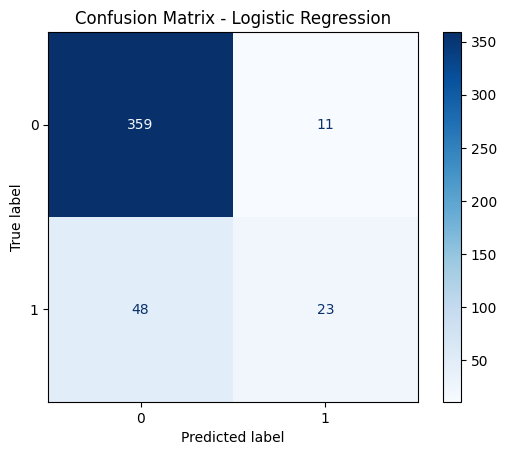

Độ chính xác của mô hình: 0.8662


In [26]:
# Huấn luyện mô hình Logistic Regression và đánh giá
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Báo cáo phân loại:") 
print(classification_report(y_test, y_pred))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred):.4f}")

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       370
           1       0.28      0.25      0.26        71

    accuracy                           0.77       441
   macro avg       0.57      0.56      0.57       441
weighted avg       0.77      0.77      0.77       441



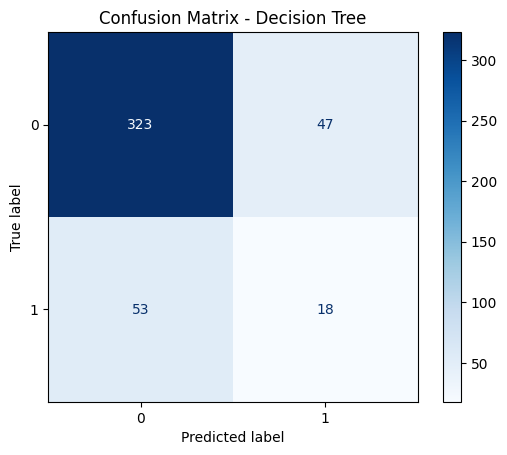

Độ chính xác của mô hình: 0.7732


In [27]:
# Huấn luyện mô hình Decision Tree và đánh giá
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

y_pred_dt = model_dt.predict(X_test)

print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_dt))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dt), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Decision Tree')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_dt):.4f}")

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       370
           1       0.42      0.11      0.18        71

    accuracy                           0.83       441
   macro avg       0.64      0.54      0.54       441
weighted avg       0.78      0.83      0.79       441



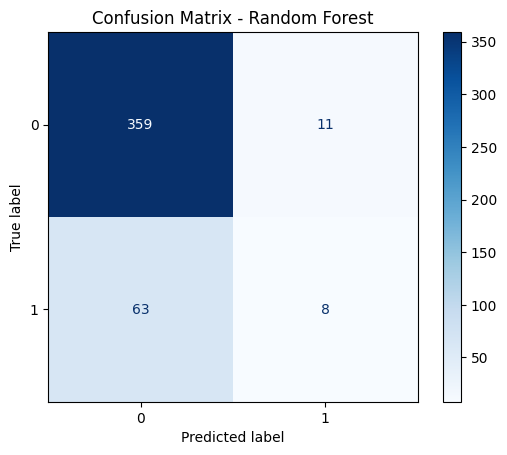

Độ chính xác của mô hình: 0.8322


In [28]:
#huấn luyện mô hình random forest
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Random Forest')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_rf):.4f}")

Giá trị k tốt nhất: 4 với độ chính xác: 0.8526
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       370
           1       0.88      0.10      0.18        71

    accuracy                           0.85       441
   macro avg       0.86      0.55      0.55       441
weighted avg       0.86      0.85      0.80       441



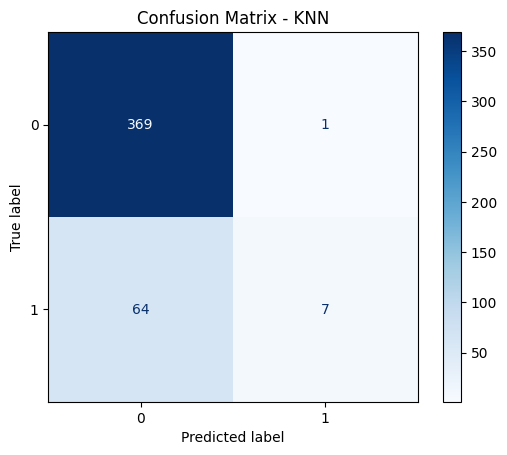

Độ chính xác của mô hình: 0.8526


In [29]:
#huấn luyện mô hình KNN (K-Nearest Neighbors) với điểm k chạy từ 1 tới 30
best_k = 1
best_accuracy = 0
for k in range(1, 31):
    model_knn = KNeighborsClassifier(n_neighbors=k)
    model_knn.fit(X_train, y_train)
    y_pred_knn = model_knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_knn)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
print(f"Giá trị k tốt nhất: {best_k} với độ chính xác: {best_accuracy:.4f}")
model_knn = KNeighborsClassifier(n_neighbors=best_k)
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_knn))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - KNN')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_knn):.4f}")



Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       370
           1       0.62      0.23      0.33        71

    accuracy                           0.85       441
   macro avg       0.74      0.60      0.62       441
weighted avg       0.83      0.85      0.82       441



c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:35:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


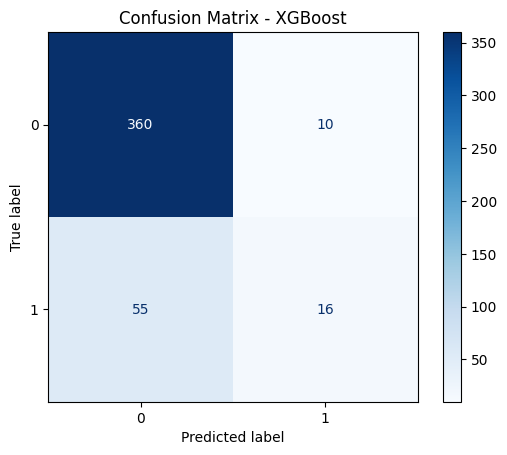

Độ chính xác của mô hình: 0.8526


In [30]:
# Huấn luyện mô hình XGBoost với dữ liệu chỉ qua tiền xử lý 
model_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_xgb))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - XGBoost')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_xgb):.4f}")

[LightGBM] [Info] Number of positive: 166, number of negative: 863
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1082
[LightGBM] [Info] Number of data points in the train set: 1029, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161322 -> initscore=-1.648427
[LightGBM] [Info] Start training from score -1.648427
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       370
           1       0.61      0.24      0.34        71

    accuracy                           0.85       441
   macro avg       0.74      0.60      0.63       441
weighted avg       0.83      0.85      0.82       441



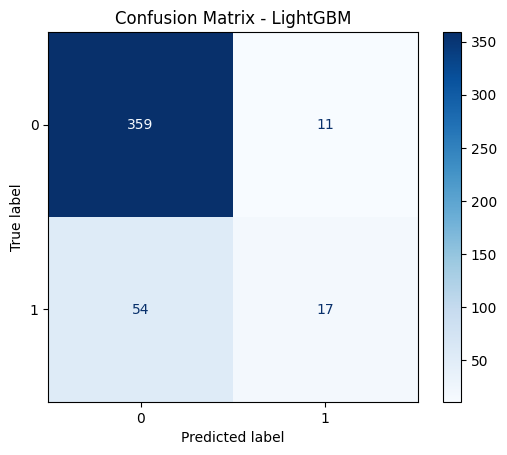

Độ chính xác của mô hình: 0.8526


In [31]:
# Huấn luyện mô hình LightGBM và đánh giá
model_lgb = lgb.LGBMClassifier(random_state=42)
model_lgb.fit(X_train, y_train)
y_pred_lgb = model_lgb.predict(X_test)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_lgb))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lgb), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - LightGBM')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_lgb):.4f}")


Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       370
           1       0.71      0.17      0.27        71

    accuracy                           0.85       441
   macro avg       0.78      0.58      0.60       441
weighted avg       0.84      0.85      0.82       441



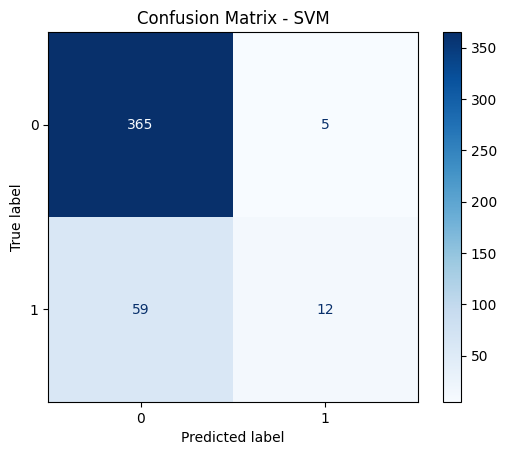

Độ chính xác của mô hình: 0.8549


In [32]:
# Huấn luyện mô hình SVMmodel_svm = SVC(random_state=42)
model_svm = SVC(random_state=42)
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_svm))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svm), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - SVM')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_svm):.4f}")


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.79354 |  0:00:00s
epoch 1  | loss: 0.63571 |  0:00:00s
epoch 2  | loss: 0.55823 |  0:00:00s
epoch 3  | loss: 0.51643 |  0:00:00s
epoch 4  | loss: 0.48777 |  0:00:00s
epoch 5  | loss: 0.48688 |  0:00:00s
epoch 6  | loss: 0.43915 |  0:00:00s
epoch 7  | loss: 0.43141 |  0:00:00s
epoch 8  | loss: 0.43529 |  0:00:00s
epoch 9  | loss: 0.42855 |  0:00:00s
epoch 10 | loss: 0.42715 |  0:00:00s
epoch 11 | loss: 0.40129 |  0:00:00s
epoch 12 | loss: 0.40376 |  0:00:00s
epoch 13 | loss: 0.41191 |  0:00:00s
epoch 14 | loss: 0.41219 |  0:00:00s
epoch 15 | loss: 0.39264 |  0:00:00s
epoch 16 | loss: 0.38938 |  0:00:00s
epoch 17 | loss: 0.38213 |  0:00:00s
epoch 18 | loss: 0.377   |  0:00:01s
epoch 19 | loss: 0.37841 |  0:00:01s
epoch 20 | loss: 0.37933 |  0:00:01s
epoch 21 | loss: 0.37102 |  0:00:01s
epoch 22 | loss: 0.35977 |  0:00:01s
epoch 23 | loss: 0.35618 |  0:00:01s
epoch 24 | loss: 0.36099 |  0:00:01s
epoch 25 | loss: 0.35286 |  0:00:01s
epoch 26 | loss: 0.35688 |  0:00:01s
e

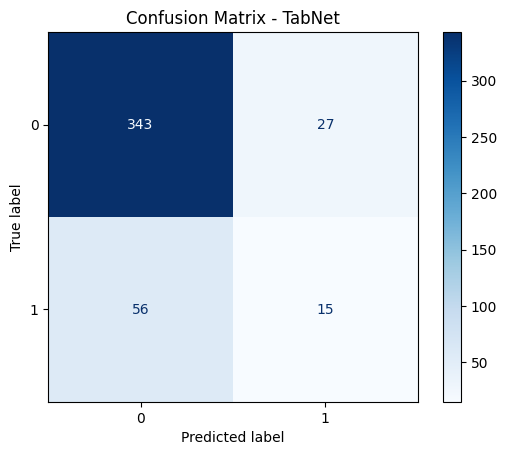

Độ chính xác của mô hình: 0.8118


In [34]:
# Huấn luyện mô hình Tabnet
# TabNetClassifier không nhận 'random_state' — dùng 'seed' nếu cần khởi tạo ngẫu nhiên
# X_train / y_train có thể đã là numpy.ndarray (sau scaler), do đó tránh gọi .values trên numpy arrays
X_tabnet = X_train if isinstance(X_train, np.ndarray) else X_train.values
y_tabnet = y_train if isinstance(y_train, np.ndarray) else y_train.values

model_tabnet = TabNetClassifier(seed=42)
model_tabnet.fit(X_tabnet, y_tabnet, max_epochs=100, patience=10, batch_size=1024, virtual_batch_size=128)

X_test_tabnet = X_test if isinstance(X_test, np.ndarray) else X_test.values
y_pred_tabnet = model_tabnet.predict(X_test_tabnet)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_tabnet))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tabnet), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - TabNet')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_tabnet):.4f}")


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


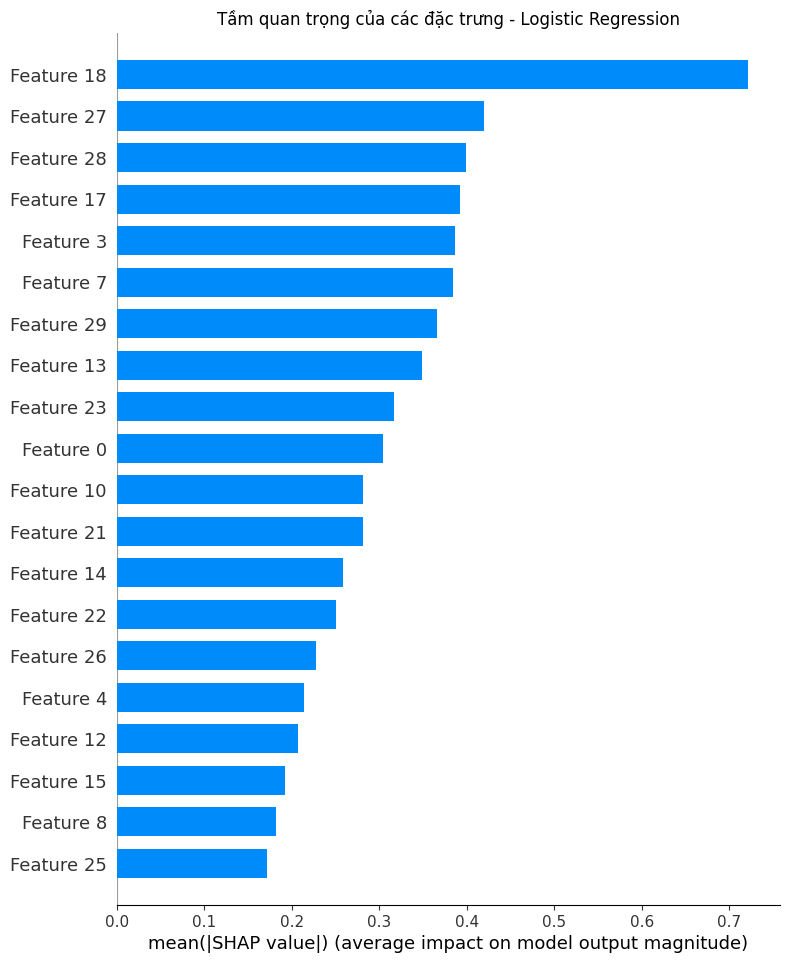

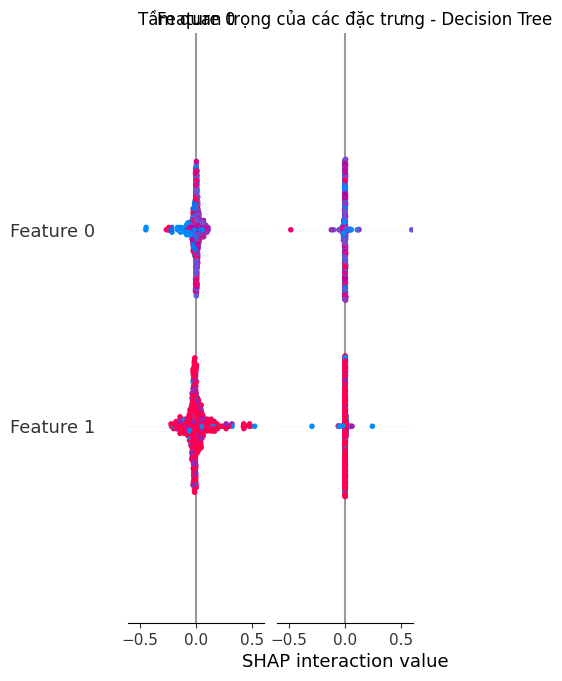

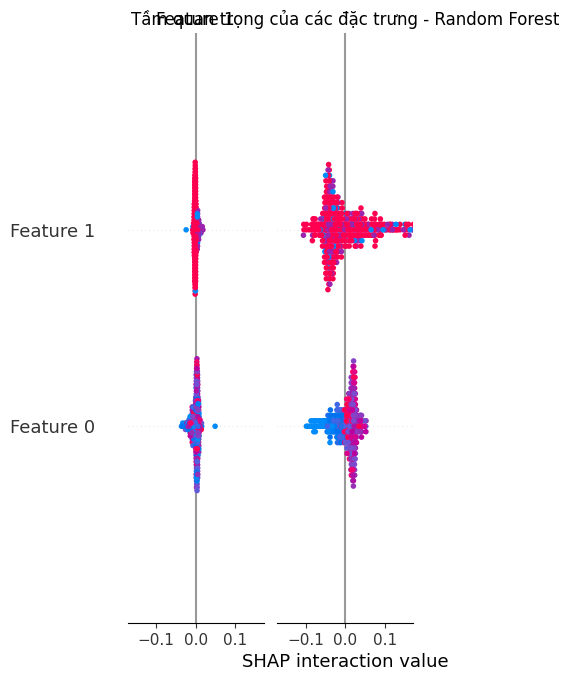

PermutationExplainer explainer: 442it [00:57,  7.56it/s]                         
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8868\221529337.py:61: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(vals, X_test, plot_type="bar", show=False)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8868\221529337.py:72: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(vals, X_test, plot_type="bar", show=False)


Không thể tạo SHAP cho KNN: The shape of the shap_values matrix does not match the shape of the provided data matrix.


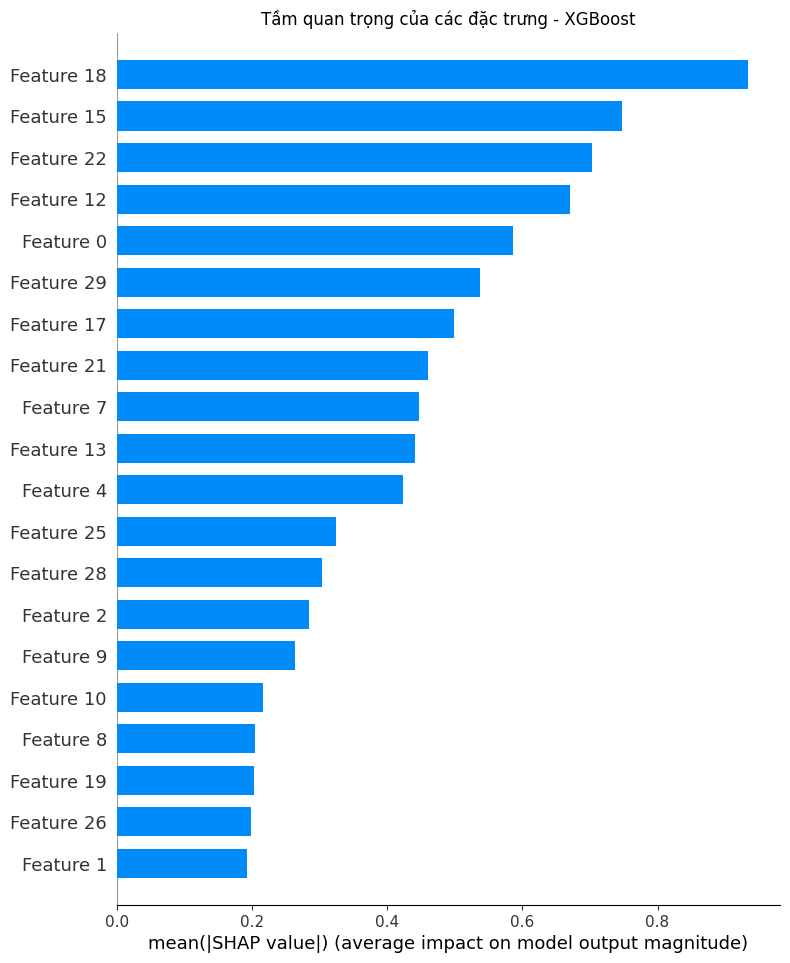

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8868\221529337.py:83: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(vals, X_test, plot_type="bar", show=False)


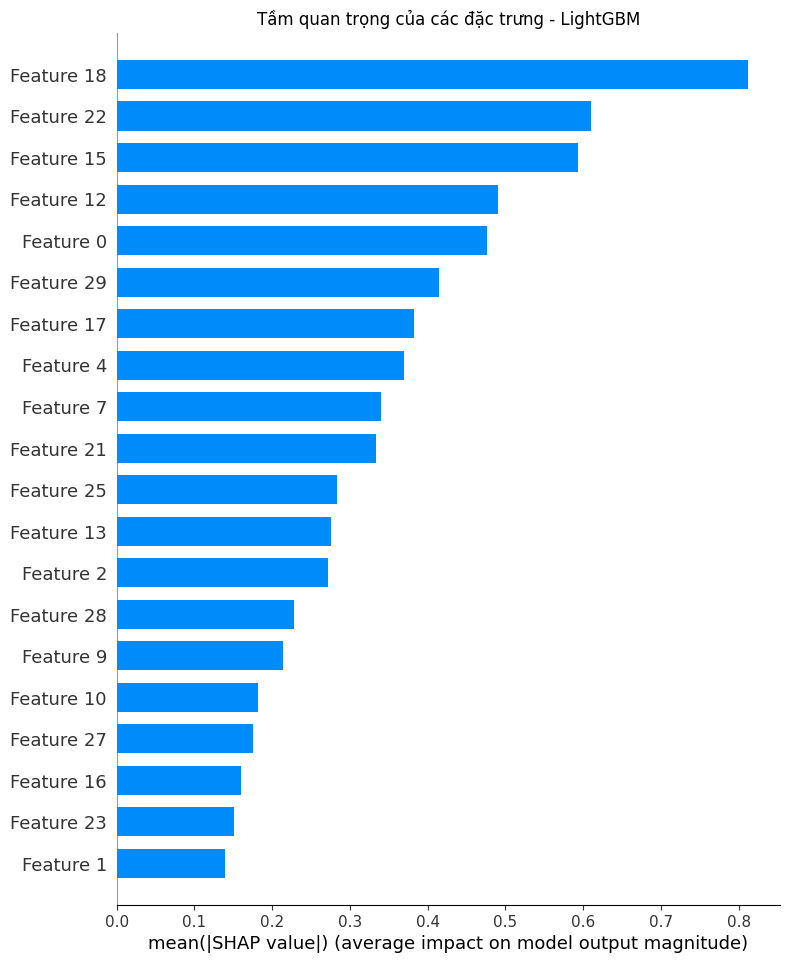

  0%|          | 0/441 [00:00<?, ?it/s]

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8868\221529337.py:101: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(vals, X_test, plot_type="bar", show=False)


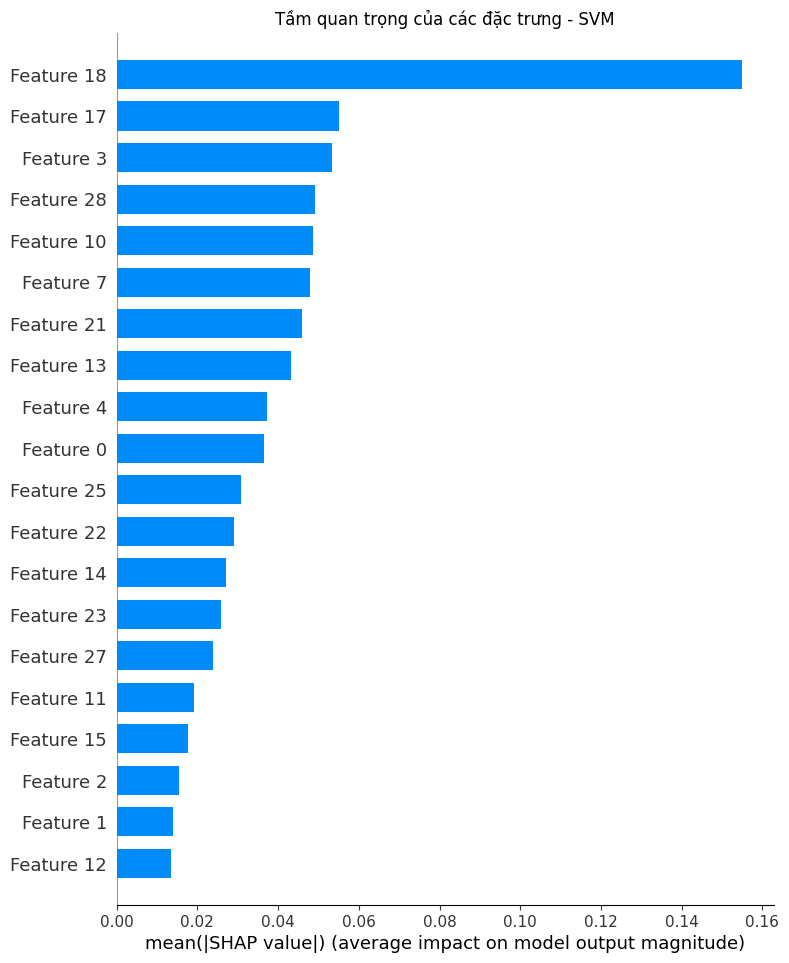

Không thể tạo SHAP cho TabNet: 'numpy.ndarray' object has no attribute 'values'


In [35]:
# Dùng SHAP để giải thích các mô hình đã huấn luyện
# Lưu ý: shap.Explainer cần một hàm callable (vd. predict_proba) hoặc explainer chuyên dụng
# Sử dụng explainer phù hợp cho từng loại mô hình và chọn giá trị giải thích cho lớp "1" (nghỉ việc)

def _extract_positive(shap_obj):
	"""
	Trả về ma trận shap values cho lớp positive (nếu trả về nhiều lớp).
	Hỗ trợ cả numpy arrays, lists và shap.Explanation objects.
	"""
	# list/tuple (ví dụ tree_explainer.shap_values trả về list cho multi-class)
	if isinstance(shap_obj, (list, tuple)):
		return shap_obj[1] if len(shap_obj) > 1 else shap_obj[0]
	# shap.Explanation object
	if hasattr(shap_obj, "values"):
		v = shap_obj.values
		# Nếu trả về shape (n_outputs, n_samples, n_features)
		if v.ndim == 3:
			return v[1] if v.shape[0] > 1 else v[0]
		return v
	# numpy array fallback
	return shap_obj

# 1) Logistic Regression - dùng LinearExplainer (tối ưu cho linear models)
try:
	explainer_lr = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
	shap_values_lr = explainer_lr.shap_values(X_test)
	vals = _extract_positive(shap_values_lr)
	shap.summary_plot(vals, X_test, plot_type="bar", show=False)
	plt.title("Tầm quan trọng của các đặc trưng - Logistic Regression")
	plt.show()
except Exception as e:
	print("Không thể tạo SHAP cho Logistic Regression:", e)

# 2) Decision Tree - dùng TreeExplainer
try:
	explainer_dt = shap.TreeExplainer(model_dt)
	shap_values_dt = explainer_dt.shap_values(X_test)
	vals = _extract_positive(shap_values_dt)
	shap.summary_plot(vals, X_test, plot_type="bar", show=False)
	plt.title("Tầm quan trọng của các đặc trưng - Decision Tree")
	plt.show()
except Exception as e:
	print("Không thể tạo SHAP cho Decision Tree:", e)

# 3) Random Forest - TreeExplainer
try:
	explainer_rf = shap.TreeExplainer(model_rf)
	shap_values_rf = explainer_rf.shap_values(X_test)
	vals = _extract_positive(shap_values_rf)
	shap.summary_plot(vals, X_test, plot_type="bar", show=False)
	plt.title("Tầm quan trọng của các đặc trưng - Random Forest")
	plt.show()
except Exception as e:
	print("Không thể tạo SHAP cho Random Forest:", e)

# 4) KNN - dùng model.predict_proba với shap.Explainer
try:
	explainer_knn = shap.Explainer(model_knn.predict_proba, X_train)
	shap_values_knn = explainer_knn(X_test)
	vals = _extract_positive(shap_values_knn)
	shap.summary_plot(vals, X_test, plot_type="bar", show=False)
	plt.title("Tầm quan trọng của các đặc trưng - KNN")
	plt.show()
except Exception as e:
	print("Không thể tạo SHAP cho KNN:", e)

# 5) XGBoost - TreeExplainer
try:
	explainer_xgb = shap.TreeExplainer(model_xgb)
	shap_values_xgb = explainer_xgb.shap_values(X_test)
	vals = _extract_positive(shap_values_xgb)
	shap.summary_plot(vals, X_test, plot_type="bar", show=False)
	plt.title("Tầm quan trọng của các đặc trưng - XGBoost")
	plt.show()
except Exception as e:
	print("Không thể tạo SHAP cho XGBoost:", e)

# 6) LightGBM - TreeExplainer
try:
	explainer_lgb = shap.TreeExplainer(model_lgb)
	shap_values_lgb = explainer_lgb.shap_values(X_test)
	vals = _extract_positive(shap_values_lgb)
	shap.summary_plot(vals, X_test, plot_type="bar", show=False)
	plt.title("Tầm quan trọng của các đặc trưng - LightGBM")
	plt.show()
except Exception as e:
	print("Không thể tạo SHAP cho LightGBM:", e)

# 7) SVM - nếu model_svm không có predict_proba, dùng KernelExplainer trên decision_function (chậm)
try:
	if hasattr(model_svm, "predict_proba"):
		explainer_svm = shap.Explainer(model_svm.predict_proba, X_train)
		shap_values_svm = explainer_svm(X_test)
		vals = _extract_positive(shap_values_svm)
	else:
		# lấy mẫu background nhỏ để giảm thời gian tính toán
		background = shap.sample(X_train, 100)
		explainer_svm = shap.KernelExplainer(lambda x: model_svm.decision_function(x), background)
		shap_values_svm = explainer_svm.shap_values(X_test, nsamples=100)
		vals = shap_values_svm  # KernelExplainer trả về numpy array cho binary
	shap.summary_plot(vals, X_test, plot_type="bar", show=False)
	plt.title("Tầm quan trọng của các đặc trưng - SVM")
	plt.show()
except Exception as e:
	print("Không thể tạo SHAP cho SVM:", e)

# 8) TabNet - dùng predict_proba (lưu ý: dùng .values cho numpy inputs nếu cần)
try:
	explainer_tabnet = shap.Explainer(model_tabnet.predict_proba, X_train.values)
	shap_values_tabnet = explainer_tabnet(X_test.values)
	vals = _extract_positive(shap_values_tabnet)
	# Chuyển vals về dạng phù hợp nếu cần
	shap.summary_plot(vals, X_test, plot_type="bar", show=False)
	plt.title("Tầm quan trọng của các đặc trưng - TabNet")
	plt.show()
except Exception as e:
	print("Không thể tạo SHAP cho TabNet:", e)




Không thể tính AUC cho TabNet: 'TabNetClassifier' object has no attribute 'network'


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8868\4230229164.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=auc_values, palette='viridis')


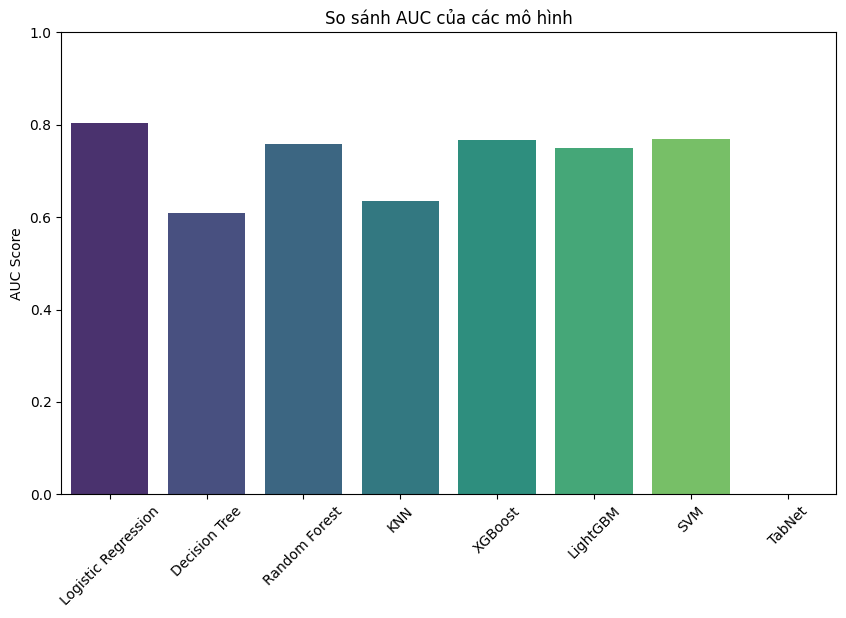

Không thể vẽ ROC Curve cho TabNet: 'TabNetClassifier' object has no attribute 'network'


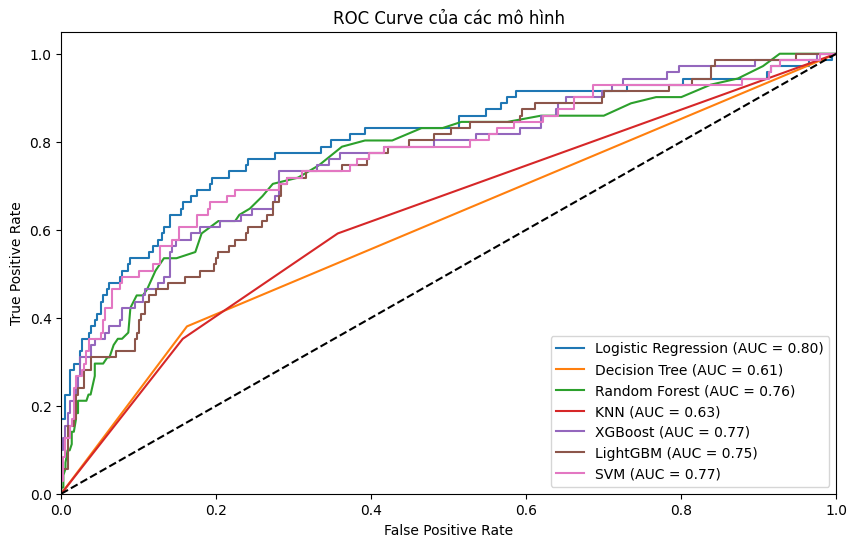

In [46]:
# Dùng tensorflow để so sánh các mô hình đã huấn luyện
models = {
    "Logistic Regression": model,
    "Decision Tree": model_dt,
    "Random Forest": model_rf,
    "KNN": model_knn,
    "XGBoost": model_xgb,
    "LightGBM": model_lgb,
    "SVM": model_svm,
    "TabNet": model_tabnet
}

def _to_array(X):
    # Nếu là pandas DataFrame/Series thì dùng .values, nếu đã là numpy.ndarray thì trả về trực tiếp
    return X if isinstance(X, np.ndarray) else getattr(X, "values", X)

auc_scores = {}
for name, mdl in models.items():
    try:
        X_input = _to_array(X_test)
        if name == "TabNet":
            # TabNet expects numpy input; X_input đảm bảo là numpy.ndarray
            y_probs = mdl.predict_proba(X_input)[:, 1]
        else:
            if hasattr(mdl, "predict_proba"):
                y_probs = mdl.predict_proba(X_input)[:, 1]
            elif hasattr(mdl, "decision_function"):
                y_probs = mdl.decision_function(X_input)
            else:
                # fallback to hard predictions
                y_probs = mdl.predict(X_input)
        auc = roc_auc_score(y_test, y_probs)
        auc_scores[name] = auc
    except Exception as e:
        # Nếu có lỗi, in thông báo và gán NaN cho model đó
        print(f"Không thể tính AUC cho {name}: {e}")
        auc_scores[name] = np.nan

# Vẽ biểu đồ AUC cho các mô hình
plt.figure(figsize=(10, 6))
model_names = list(auc_scores.keys())
auc_values = [auc_scores[m] for m in model_names]
sns.barplot(x=model_names, y=auc_values, palette='viridis')
plt.xticks(rotation=45)
plt.ylabel('AUC Score')
plt.title('So sánh AUC của các mô hình')
plt.ylim(0, 1)
plt.show()

# Vẽ ROC Curve cho các mô hình
plt.figure(figsize=(10, 6))
for name, mdl in models.items():
    try:
        X_input = _to_array(X_test)
        if name == "TabNet":
            y_probs = mdl.predict_proba(X_input)[:, 1]
        else:
            if hasattr(mdl, "predict_proba"):
                y_probs = mdl.predict_proba(X_input)[:, 1]
            elif hasattr(mdl, "decision_function"):
                y_probs = mdl.decision_function(X_input)
            else:
                y_probs = mdl.predict(X_input)
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_scores[name]:.2f})')
    except Exception as e:
        print(f"Không thể vẽ ROC Curve cho {name}: {e}")
plt.plot([0, 1], [0, 1], 'k--')  # Đường chéo
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve của các mô hình')
plt.legend(loc='lower right')
plt.show()



Xây dựng mô hình với bộ dữ liệu đã qua resample bằng phương pháp SMOTE

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       370
           1       0.39      0.73      0.51        71

    accuracy                           0.77       441
   macro avg       0.66      0.76      0.68       441
weighted avg       0.85      0.77      0.80       441



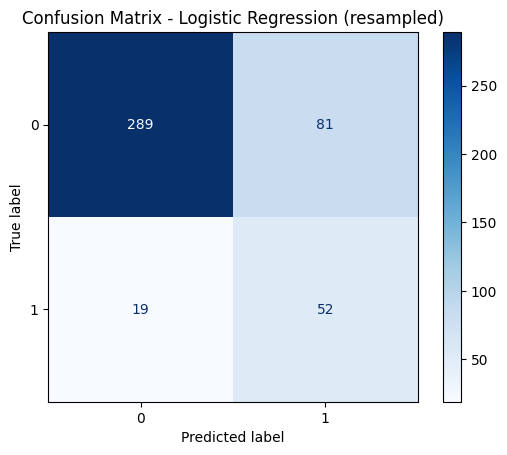

Độ chính xác của mô hình: 0.7732


In [47]:
#Dùng data đã qua resample để train model Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_resampled_train, y_resampled_train)
y_pred = model.predict(X_test)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Logistic Regression (resampled)')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred):.4f}")

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       370
           1       0.31      0.38      0.34        71

    accuracy                           0.76       441
   macro avg       0.59      0.61      0.60       441
weighted avg       0.78      0.76      0.77       441



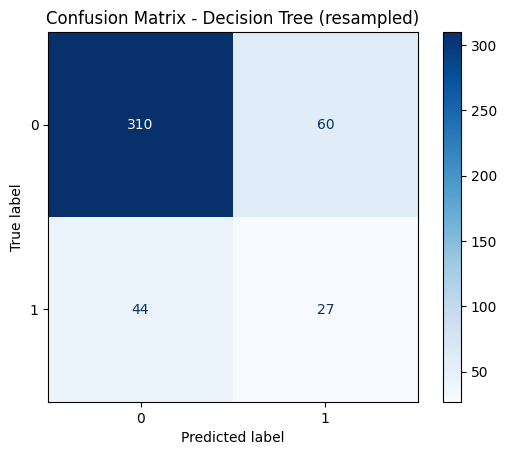

Độ chính xác của mô hình: 0.7642


In [48]:
# Huấn luyện mô hình Decision Tree và đánh giá với dữ liệu đã qua resample
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_resampled_train, y_resampled_train)

y_pred_dt = model_dt.predict(X_test)

print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_dt))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dt), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Decision Tree (resampled)')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_dt):.4f}")

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       370
           1       0.53      0.23      0.32        71

    accuracy                           0.84       441
   macro avg       0.70      0.59      0.61       441
weighted avg       0.81      0.84      0.82       441



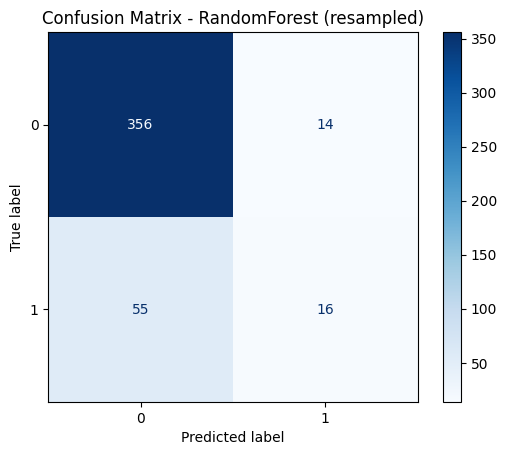

Độ chính xác của mô hình: 0.8435


In [49]:
# Huấn luyện mô hình RandomForest và đánh giá với dữ liệu đã qua resample
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_resampled_train, y_resampled_train)
y_pred_rf = model_rf.predict(X_test)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - RandomForest (resampled)')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_rf):.4f}")

Giá trị k tốt nhất: 2 với độ chính xác: 0.7642
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       370
           1       0.30      0.35      0.32        71

    accuracy                           0.76       441
   macro avg       0.59      0.60      0.59       441
weighted avg       0.78      0.76      0.77       441



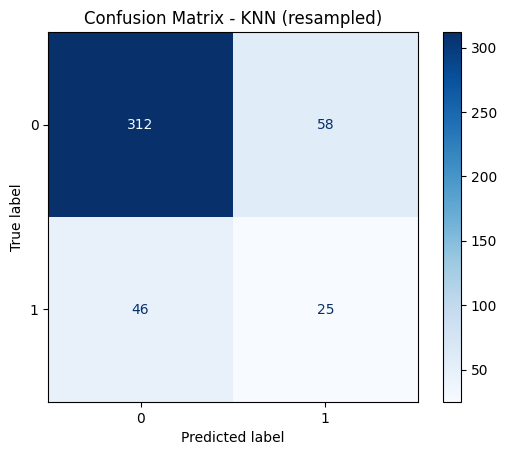

Độ chính xác của mô hình: 0.7642


In [50]:
# Huấn luyện mô hình KNN với dữ liệu đã qua resample cho K chạy từ 1 đến 30
best_k = 1
best_accuracy = 0
for k in range(1, 31):
    model_knn = KNeighborsClassifier(n_neighbors=k)
    model_knn.fit(X_resampled_train, y_resampled_train)
    y_pred_knn = model_knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_knn)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
print(f"Giá trị k tốt nhất: {best_k} với độ chính xác: {best_accuracy:.4f}")
model_knn = KNeighborsClassifier(n_neighbors=best_k)
model_knn.fit(X_resampled_train, y_resampled_train)
y_pred_knn = model_knn.predict(X_test)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_knn))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - KNN (resampled)')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_knn):.4f}")

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       370
           1       0.67      0.31      0.42        71

    accuracy                           0.86       441
   macro avg       0.77      0.64      0.67       441
weighted avg       0.85      0.86      0.84       441



c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:52:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


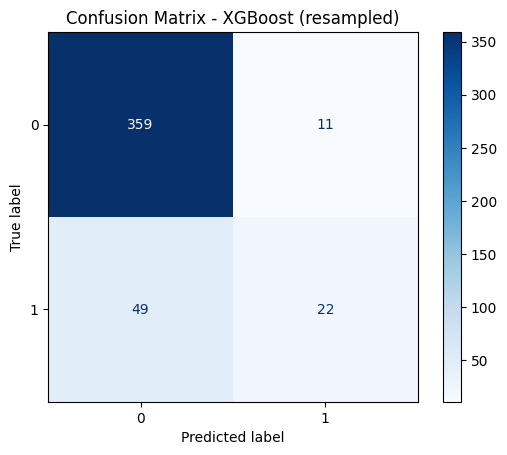

Độ chính xác của mô hình: 0.8639


In [51]:
# Huấn luyện mô hình XGBoost với dữ liệu đã qua resample
model_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
model_xgb.fit(X_resampled_train, y_resampled_train)
y_pred_xgb = model_xgb.predict(X_test)

print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_xgb))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - XGBoost (resampled)')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_xgb):.4f}")

[LightGBM] [Info] Number of positive: 863, number of negative: 863
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5939
[LightGBM] [Info] Number of data points in the train set: 1726, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       370
           1       0.61      0.28      0.38        71

    accuracy                           0.85       441
   macro avg       0.74      0.62      0.65       441
weighted avg       0.83      0.85      0.83       441



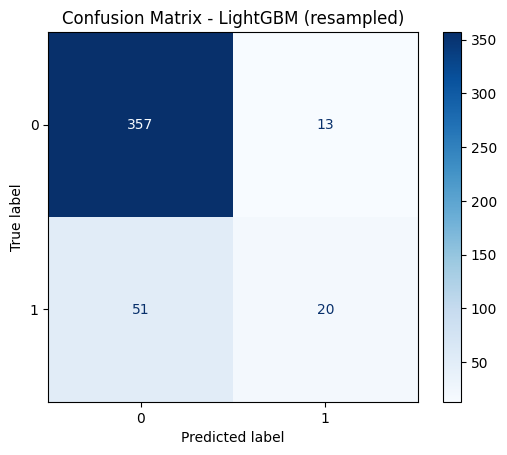

Độ chính xác của mô hình: 0.8549


In [52]:
# Huấn luyện mô hình LightGBM với dữ liệu đã qua resample
model_lgb = lgb.LGBMClassifier(random_state=42)
model_lgb.fit(X_resampled_train, y_resampled_train)
y_pred_lgb = model_lgb.predict(X_test)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_lgb))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lgb), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - LightGBM (resampled)')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_lgb):.4f}")

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       370
           1       0.54      0.46      0.50        71

    accuracy                           0.85       441
   macro avg       0.72      0.69      0.71       441
weighted avg       0.84      0.85      0.85       441



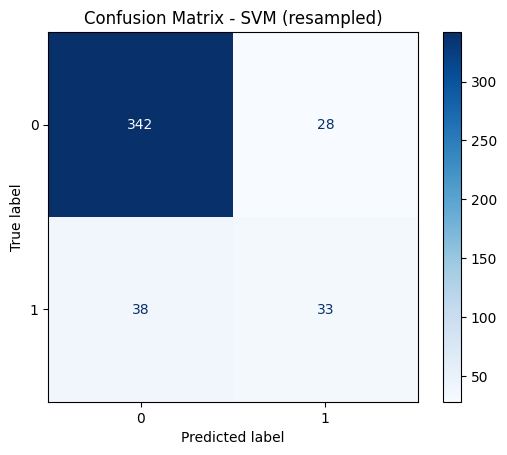

Độ chính xác của mô hình: 0.8503


In [53]:
# Huấn luyện mô hình SVM với dữ liệu đã qua resample
model_svm = SVC(random_state=42)
model_svm.fit(X_resampled_train, y_resampled_train)
y_pred_svm = model_svm.predict(X_test)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_svm))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svm), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - SVM (resampled)')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_svm):.4f}")

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.93394 |  0:00:00s
epoch 1  | loss: 0.82568 |  0:00:00s
epoch 2  | loss: 0.7451  |  0:00:00s
epoch 3  | loss: 0.71337 |  0:00:00s
epoch 4  | loss: 0.67885 |  0:00:00s
epoch 5  | loss: 0.67111 |  0:00:00s
epoch 6  | loss: 0.62925 |  0:00:00s
epoch 7  | loss: 0.63834 |  0:00:00s
epoch 8  | loss: 0.63088 |  0:00:00s
epoch 9  | loss: 0.60552 |  0:00:00s
epoch 10 | loss: 0.61069 |  0:00:00s
epoch 11 | loss: 0.59388 |  0:00:00s
epoch 12 | loss: 0.58176 |  0:00:00s
epoch 13 | loss: 0.58545 |  0:00:00s
epoch 14 | loss: 0.58898 |  0:00:00s
epoch 15 | loss: 0.54916 |  0:00:01s
epoch 16 | loss: 0.56044 |  0:00:01s
epoch 17 | loss: 0.57801 |  0:00:01s
epoch 18 | loss: 0.55563 |  0:00:01s
epoch 19 | loss: 0.54792 |  0:00:01s
epoch 20 | loss: 0.5478  |  0:00:01s
epoch 21 | loss: 0.52619 |  0:00:01s
epoch 22 | loss: 0.50413 |  0:00:01s
epoch 23 | loss: 0.51024 |  0:00:01s
epoch 24 | loss: 0.52862 |  0:00:01s
epoch 25 | loss: 0.50081 |  0:00:01s
epoch 26 | loss: 0.52206 |  0:00:01s
e

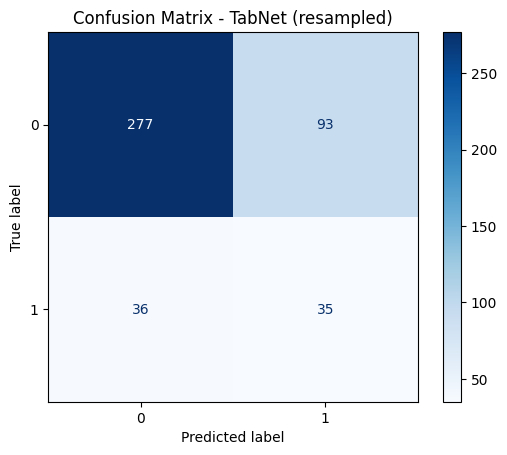

Độ chính xác của mô hình: 0.7075


In [55]:
# Huấn luyện mô hình Tabnet với dữ liệu đã qua resample
model_tabnet = TabNetClassifier(seed=42)

# đảm bảo inputs là numpy.ndarray (np.asarray hỗ trợ cả pandas và numpy)
X_tabnet_train = np.asarray(X_resampled_train)
y_tabnet_train = np.asarray(y_resampled_train)
X_tabnet_test = np.asarray(X_test)

model_tabnet.fit(X_tabnet_train, y_tabnet_train, max_epochs=100, patience=10, batch_size=1024, virtual_batch_size=128)

y_pred_tabnet = model_tabnet.predict(X_tabnet_test)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_tabnet))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tabnet), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - TabNet (resampled)')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_tabnet):.4f}")

Xây dựng mô hình với bộ dữ liệu đã qua resample bằng phương pháp SMOTE và loại bỏ outliers

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       193
           1       0.38      0.73      0.50        41

    accuracy                           0.75       234
   macro avg       0.66      0.74      0.67       234
weighted avg       0.83      0.75      0.77       234



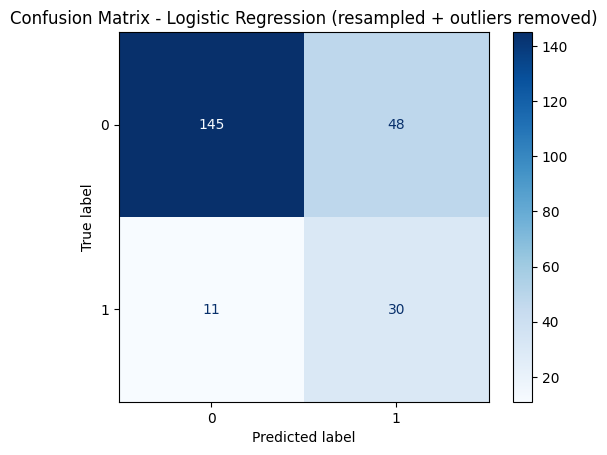

Độ chính xác của mô hình: 0.7479


In [56]:
# Dùng data đã qua resample và loại bỏ outliers để train model
model = LogisticRegression(max_iter=1000)
model.fit(X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train)
y_pred = model.predict(X_cleaned_outliers_test)
print("Báo cáo phân loại:")
print(classification_report(y_cleaned_outliers_test, y_pred))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_cleaned_outliers_test, y_pred), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Logistic Regression (resampled + outliers removed)')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_cleaned_outliers_test, y_pred):.4f}")

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.87      0.80      0.84       193
           1       0.32      0.44      0.37        41

    accuracy                           0.74       234
   macro avg       0.60      0.62      0.60       234
weighted avg       0.77      0.74      0.75       234



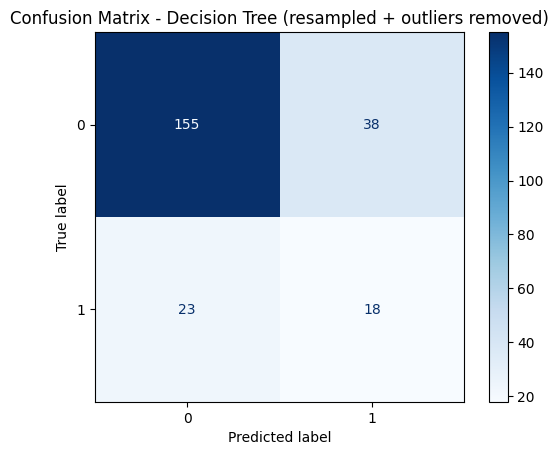

Độ chính xác của mô hình: 0.7393


In [57]:
# Dùng data đã qua resample và clean outliers để train mô hình decision tree
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train)

y_pred_dt = model_dt.predict(X_cleaned_outliers_test)

print("Báo cáo phân loại:")
print(classification_report(y_cleaned_outliers_test, y_pred_dt))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_cleaned_outliers_test, y_pred_dt), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Decision Tree (resampled + outliers removed)')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_cleaned_outliers_test, y_pred_dt):.4f}")

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92       193
           1       0.67      0.34      0.45        41

    accuracy                           0.85       234
   macro avg       0.77      0.65      0.68       234
weighted avg       0.84      0.85      0.83       234



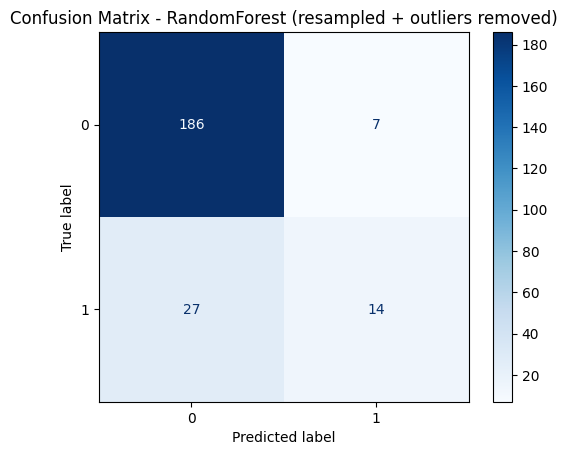

Độ chính xác của mô hình: 0.8547


In [58]:
# Huấn luyện mô hình RandomForest và đánh giá với dữ liệu đã qua resample và loại bỏ outliers
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train)
y_pred_rf = model_rf.predict(X_cleaned_outliers_test)
print("Báo cáo phân loại:")
print(classification_report(y_cleaned_outliers_test, y_pred_rf))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_cleaned_outliers_test, y_pred_rf), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - RandomForest (resampled + outliers removed)')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_cleaned_outliers_test, y_pred_rf):.4f}")

Giá trị k tốt nhất: 2 với độ chính xác: 0.7350
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       193
           1       0.32      0.46      0.38        41

    accuracy                           0.74       234
   macro avg       0.60      0.63      0.61       234
weighted avg       0.78      0.74      0.75       234



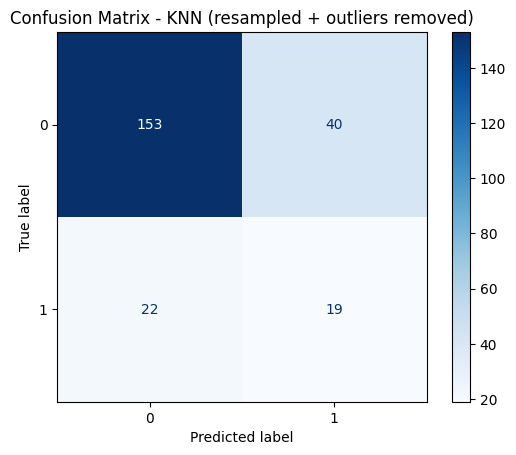

Độ chính xác của mô hình: 0.7350


In [59]:
# Huan luyện mô hình KNN với dữ liệu đã qua resample và loại bỏ outliers cho K chạy từ 1 đến 30
best_k = 1
best_accuracy = 0
for k in range(1, 31):
    model_knn = KNeighborsClassifier(n_neighbors=k)
    model_knn.fit(X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train)
    y_pred_knn = model_knn.predict(X_cleaned_outliers_test)
    accuracy = accuracy_score(y_cleaned_outliers_test, y_pred_knn)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
print(f"Giá trị k tốt nhất: {best_k} với độ chính xác: {best_accuracy:.4f}")
model_knn = KNeighborsClassifier(n_neighbors=best_k)   
model_knn.fit(X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train)
y_pred_knn = model_knn.predict(X_cleaned_outliers_test)
print("Báo cáo phân loại:")
print(classification_report(y_cleaned_outliers_test, y_pred_knn))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_cleaned_outliers_test, y_pred_knn), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - KNN (resampled + outliers removed)')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_cleaned_outliers_test, y_pred_knn):.4f}")

In [ ]:
# Huấn luyện mô hình XGBoost với dữ liệu đã qua resample và loại bỏ outliers
model_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
model_xgb.fit(X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train)
y_pred_xgb = model_xgb.predict(X_cleaned_outliers_test)

print("Báo cáo phân loại:")
print(classification_report(y_cleaned_outliers_test, y_pred_xgb))
disp = ConfusionMatrixDisplay(confusion_matrix(y_cleaned_outliers_test, y_pred_xgb), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - XGBoost (resampled + outliers removed)')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_cleaned_outliers_test, y_pred_xgb):.4f}")

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       193
           1       0.71      0.49      0.58        41

    accuracy                           0.88       234
   macro avg       0.81      0.72      0.75       234
weighted avg       0.87      0.88      0.87       234

Ma trận nhầm lẫn:
[[185   8]
 [ 21  20]]
Độ chính xác của mô hình: 0.8761


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:55:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [61]:
# Huấn luyện mô hình LightGBM với dữ liệu đã qua resample và loại bỏ outliers
model_lgb = lgb.LGBMClassifier(random_state=42)
model_lgb.fit(X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train)
y_pred_lgb = model_lgb.predict(X_cleaned_outliers_test)
print("Báo cáo phân loại:") 
print(classification_report(y_cleaned_outliers_test, y_pred_lgb))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_cleaned_outliers_test, y_pred_lgb))
print(f"Độ chính xác của mô hình: {accuracy_score(y_cleaned_outliers_test, y_pred_lgb):.4f}")

[LightGBM] [Info] Number of positive: 448, number of negative: 448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4179
[LightGBM] [Info] Number of data points in the train set: 896, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       193
           1       0.75      0.37      0.49        41

    accuracy                           0.87       234
   macro avg       0.81      0.67      0.71       234
weighted avg       0.86      0.87      0.85       2

In [62]:
# Huấn luyện mô hình SVM với dữ liệu đã qua resample và loại bỏ outliers
model_svm = SVC(random_state=42)
model_svm.fit(X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train)
y_pred_svm = model_svm.predict(X_cleaned_outliers_test)
print("Báo cáo phân loại:")
print(classification_report(y_cleaned_outliers_test, y_pred_svm))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_cleaned_outliers_test, y_pred_svm))
print(f"Độ chính xác của mô hình: {accuracy_score(y_cleaned_outliers_test, y_pred_svm):.4f}")

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       193
           1       0.46      0.44      0.45        41

    accuracy                           0.81       234
   macro avg       0.67      0.67      0.67       234
weighted avg       0.81      0.81      0.81       234

Ma trận nhầm lẫn:
[[172  21]
 [ 23  18]]
Độ chính xác của mô hình: 0.8120


In [63]:
# Huấn luyện mô hình Tabnet với dữ liệu đã qua resample
model_tabnet = TabNetClassifier(seed=42)
model_tabnet.fit(X_resampled_train.values, y_resampled_train.values, max_epochs=100, patience=10, batch_size=1024, virtual_batch_size=128)
y_pred_tabnet = model_tabnet.predict(X_test.values)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_tabnet))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tabnet), display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - TabNet (resampled)')
plt.show()
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_tabnet):.4f}")

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
# Dùng tensorflow để xây dựng mô hình ANN (Artificial Neural Network)
model_ann = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_top_12_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_ann.fit(X_top_12_train, y_top_12_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
y_pred_ann = (model_ann.predict(X_top_12_test) > 0.5).astype("int32")
print("Báo cáo phân loại:")
print(classification_report(y_top_12_test, y_pred_ann))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_top_12_test, y_pred_ann))
print(f"Độ chính xác của mô hình: {accuracy_score(y_top_12_test, y_pred_ann):.4f}")


In [ ]:
# Dùng tensorflow để xây dựng mô hình ANN (Artificial Neural Network)
model_ann = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_resampled_top12_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_ann.fit(X_resampled_top12_train, y_resampled_top_12_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

y_pred_ann = (model_ann.predict(X_top_12_test) > 0.5).astype("int32")
print("Báo cáo phân loại:")
print(classification_report(y_top_12_test, y_pred_ann))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_top_12_test, y_pred_ann))
print(f"Độ chính xác của mô hình: {accuracy_score(y_top_12_test, y_pred_ann):.4f}")


# Tinh chỉnh các mô hình


In [ ]:

# Tinh chỉnh mô hình sử dụng GridSearchCV cho Random Forest và Logistic Regression
# GridSearch cho Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_rf.fit(X_resampled_train, y_resampled_train)
print(f"Best parameters for Random Forest: {grid_rf.best_params_}")
print(f"Best accuracy for Random Forest: {grid_rf.best_score_:.4f}")

# GridSearch cho Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_lr.fit(X_resampled_train, y_resampled_train)
print(f"Best parameters for Logistic Regression: {grid_lr.best_params_}")
print(f"Best accuracy for Logistic Regression: {grid_lr.best_score_:.4f}")

# Đánh giá lại trên tập kiểm tra
best_rf = grid_rf.best_estimator_
best_lr = grid_lr.best_estimator_

y_pred_rf_best = best_rf.predict(X_test)
y_pred_lr_best = best_lr.predict(X_test)

print("\nRandom Forest sau tinh chỉnh:")
print(classification_report(y_test, y_pred_rf_best))
print(f"Độ chính xác: {accuracy_score(y_test, y_pred_rf_best):.4f}")

print("\nLogistic Regression sau tinh chỉnh:")
print(classification_report(y_test, y_pred_lr_best))
print(f"Độ chính xác: {accuracy_score(y_test, y_pred_lr_best):.4f}")

Lưu lại các mô hình đã qua huấn luyện và các dataset qua các giai đoạn tiền xử lý khác nhau

In [ ]:
# Lưu mô hình đã huấn luyện sử dụng joblib
joblib.dump(best_rf, 'best_random_forest_model.pkl')
joblib.dump(best_lr, 'best_logistic_regression_model.pkl')
joblib.dump(model_knn, 'best_knn_model.pkl')
joblib.dump(model_dt, 'best_decision_tree_model.pkl')
joblib.dump(model_tabnet, 'best_tabnet_model.pkl')
joblib.dump(model_xgb, 'best_xgboost_model.pkl')
joblib.dump(model_lgb, 'best_lightgbm_model.pkl')
joblib.dump(model_svm, 'best_svm_model.pkl')
# Load mô hình và dự đoán lại để kiểm tra
loaded_rf = joblib.load('best_random_forest_model.pkl')
loaded_lr = joblib.load('best_logistic_regression_model.pkl')
loaded_knn = joblib.load('best_knn_model.pkl')
loaded_dt = joblib.load('best_decision_tree_model.pkl')
loaded_tabnet = joblib.load('best_tabnet_model.pkl')
loaded_xgb = joblib.load('best_xgboost_model.pkl')
loaded_lgb = joblib.load('best_lightgbm_model.pkl')
loaded_svm = joblib.load('best_svm_model.pkl')
